# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import networkx as nx
import os


/home/bernas/.pyenv/versions/3.11.0/envs/MVA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Useful functions :

## modified plot cluster

In [2]:
def plot_clusters_fig(X, Y, ax=plt, show=False):
    """
    Function to plot clusters.

    :param X: (num_samples, 2) matrix of 2-dimensional samples
    :param Y:  (num_samples, ) vector of cluster assignment
    :param fignum: figure name
    :param show: If True, call plt.show()
    :return:
    """
    K = Y.max() + 1
    for k in range(K):
        ax.plot(X[Y == k, 0], X[Y == k, 1], 'o')
    if show:
        plt.show()


## modified plot edges & points

In [3]:
def plot_edges_and_points_fig(X, Y, W, ax=plt, title=''):
    colors = ['go-', 'ro-', 'co-', 'ko-', 'yo-', 'mo-']
    n = len(X)
    G = nx.from_numpy_array(W)
    nx.draw_networkx_edges(G, X, ax=ax)
    for i in range(n):
        ax.plot(X[i, 0], X[i, 1], colors[int(Y[i])])
    ax.set_title(title)
    ax.axis('equal')

## modified matrix graph plot

In [4]:
def plot_graph_matrix_fig(X, Y, W, ax=plt, fignum='graph matrix'):
    fig, (ax1, ax2) = plt.subplots(1, 2, num=fignum)
    ax1.cla()
    ax2.cla()
    plot_edges_and_points_fig(X, Y, W, ax=ax1)
    ax2.imshow(W, extent=[0, 1, 0, 1])
    plt.show()


## Generating the data

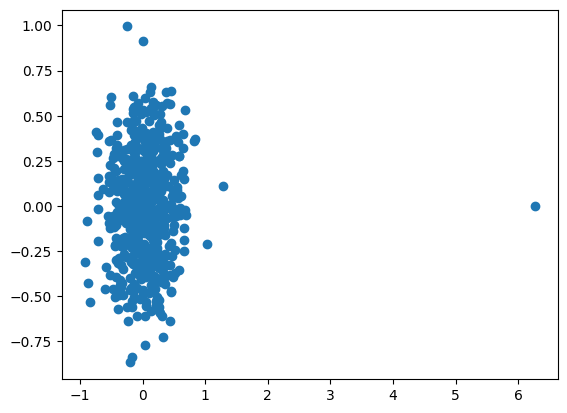

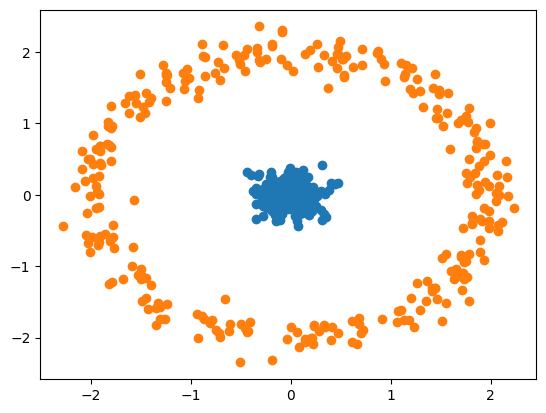

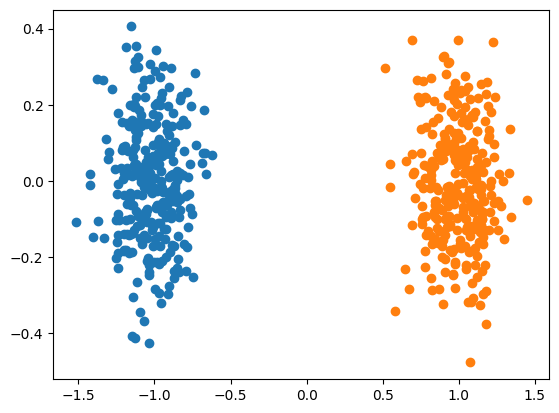

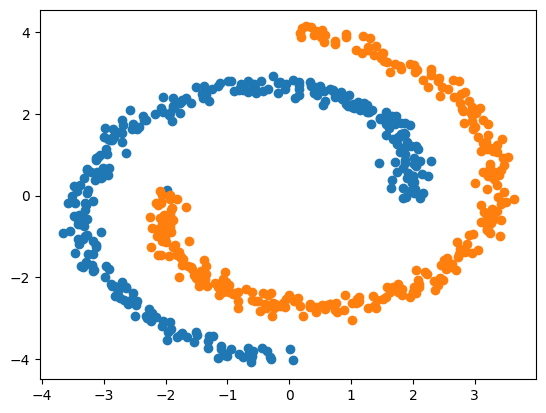

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/VSC/MVA/GML/spectral_clustering/generate_data.py
Type:      function

In [2]:
# Example

for fn in [worst_case_blob, point_and_circle, blobs, two_moons]:  #  try [worst_case_blob, point_and_circle, blobs, two_moons]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [4]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
    # Defining the similarity function
    d = lambda x, y: np.exp(-np.linalg.norm(x-y)**2/(2*var))

    # Similarities :
    similarities = np.zeros((n, n))
    for i in range(n):
        for j in range(i,n):
            similarities[i,j] = d(X[i], X[j])
            # Symetry
            similarities[j,i] = similarities[i,j]
        similarities[i,i] = 0.

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = similarities*(similarities>=eps)
        

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        if k > n:
            raise ValueError("k should be smaller than the number of samples")
        
        for i in range(n):
            k_indices = np.argpartition(-similarities[i,:], k)[:k]
            #k_indices = np.argsort( -similarities[i,:])[:k] 
            # print('pour' + str(i) + ' on a :')
            # print(np.max(similarities[i,k_indices]))
            W[i,k_indices] = similarities[i,k_indices]
            W[k_indices,i] = similarities[i,k_indices]

    return W


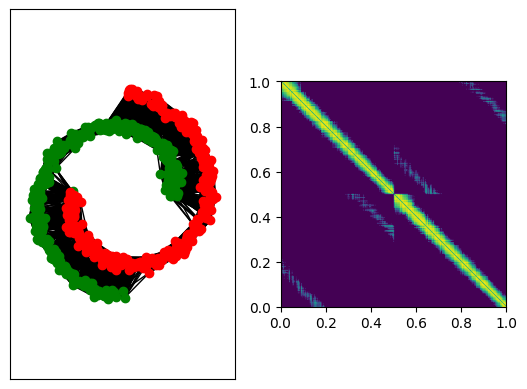

In [4]:
# Example

W = build_similarity_graph(X, k=50)
# W[0, 599] = 1    # add two placeholder edges to reproduce example picture
# W[10, 500] = 1   # 


plot_graph_matrix(X, Y, 1e20*W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [5]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    # laplacian matrix
    if laplacian_normalization=='unn':
        # degree matrix
        D = np.diag(W.sum(axis=1))
        L = D - W
    elif laplacian_normalization=='sym':
        # inversed half degree matrix
        D_half = np.diag(1/np.sqrt(W.sum(axis=1)))
        L = np.eye(W.shape[0]) - np.dot(np.dot(D_half, W), D_half)
    elif laplacian_normalization=='rw':
        # inversed degree matrix
        D_inv = np.diag(1/W.sum(axis=1))
        L = np.eye(W.shape[0]) - np.dot(D_inv, W)
    else :
        raise ValueError("Unknown normalization method :" + laplacian_normalization)
    
    # for example (unnormalized): L = D - W
    return L

## Clustering

In [6]:
import scipy as sc

def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, max_clusters=10, threshold = None, verbose=False, thresh_method='sum'):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    # Convert into a sparsed matrix
    n = L.shape[0]
    L_sparse = sc.sparse.csr_matrix(L)
    E, U = sc.sparse.linalg.eigsh(L_sparse, k=min(max(max_clusters, np.floor(10**(np.log10(n)//2))),n), which='SM')
    E, U = np.real(E), np.real(U)
    # Normalization
    U = U / np.linalg.norm(U, axis=0)
    # Sort eigenvalues & eigenvectors
    idx = np.argsort(E)
    U = U[:,idx]
    E = E[idx]
    if verbose:
        # plot the eigenvalues in order
        Ex = np.arange(len(E)) + 1
        plt.plot(Ex, E, marker='o')
        plt.title('Laplacian Sorted Eigenvalues')
        plt.show()

        
    # Eigen vectors selection
    if chosen_eig_indices is None:
        # Adaptive choice of eigenvectors
        if threshold is not None:
            # If there is a threshold, we select the eigenvalues that participated the least in the trace value and only keep them
            E /= np.sum(E)
            if thresh_method == 'diff':
                diff = np.diff(E)
                low_eig_indices = np.argmax(diff > threshold)
                low_eig_indices = np.arange(low_eig_indices + 1)
            elif thresh_method == 'sum':
                low_eig_indices = np.where(np.cumsum(E) > threshold)[0][0]
                low_eig_indices = np.arange(low_eig_indices + 1)
            else :
                raise ValueError("Unknown threshold method :" + thresh_method)
            if len(low_eig_indices) == 0: low_eig_indices = np.append(low_eig_indices, 0) # If no eigenvalue is selected, we keep the first one and the second one will then also be added
            if len(low_eig_indices) == 1: low_eig_indices = np.append(low_eig_indices, low_eig_indices[0] + 1)
            if thresh_method == 'diff':
                diff = diff[low_eig_indices]
            elif thresh_method == 'sum':
                E = E[low_eig_indices]
                E = np.cumsum(E)
                diff = np.diff(E)
            if verbose:
                print('List of eigen values : ' + str(low_eig_indices))
                print('Threshold choice of eigenvectors : ' + str(threshold))
        else:
            diff = np.diff(E)
        highest_diff = np.argmax(diff) + 1
        chosen_eig_indices = np.arange(highest_diff)
        if verbose:
            print('Adaptative choice of eigenvectors')
            print('Number of cluster selected : ' + str(highest_diff))
    else:
        if verbose:
            print('User choice of eigenvectors')
    U = U[:, chosen_eig_indices]

    # K-means clustering on the selected eigenvectors
    Y = np.zeros(n)
    kmeans = KMeans(n_clusters=num_classes).fit(U)
    Y = kmeans.labels_
    
    # kmeans = KMeans(n_clusters=len(chosen_eig_indices)).fit(U)
    # cluster_centers = kmeans.cluster_centers_
    # kmeans_c = KMeans(n_clusters=num_classes).fit(cluster_centers)
    # new_class_labels = kmeans_c.predict(cluster_centers)
    # Y = new_class_labels[kmeans.labels_]

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    return Y

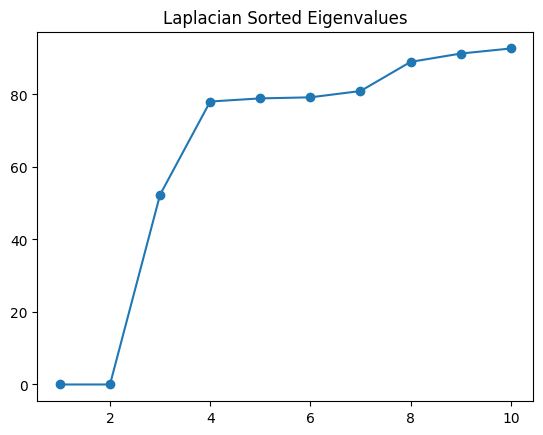

List of eigen values : [0 1 2]
Threshold choice of eigenvectors : 0.1
Adaptative choice of eigenvectors
Number of cluster selected : 2


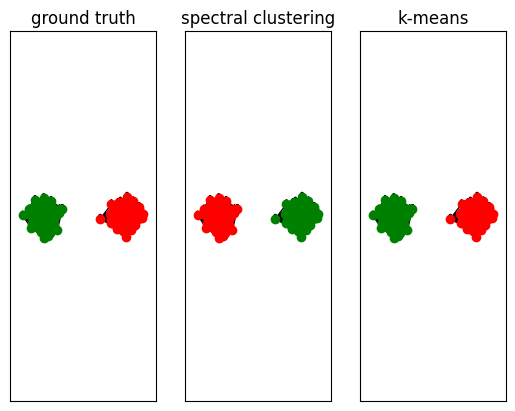

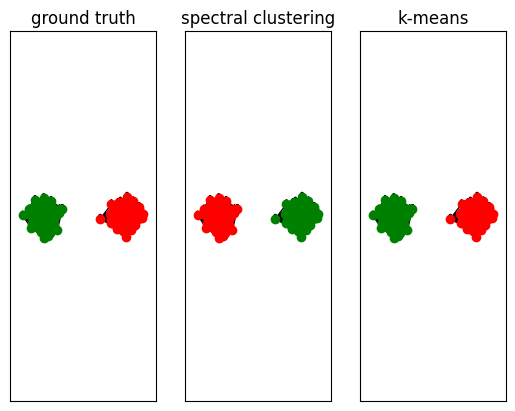

In [7]:
# Example

#X, Y = two_moons(num_samples=600)

X, Y = blobs(num_samples=600)

num_classes = 2
eps = 0.1
W = build_similarity_graph(X, var=0.1, eps=eps, k=0)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=num_classes, threshold = 0.1, verbose=True)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Y_rec = spectral_clustering(L, num_classes=num_classes, chosen_eig_indices=[0, 1])

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [7]:
def parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=None, parameter_type='k', parameter_candidate=[1, 2], threshold=None, thresh_method='sum'):
    """
    A function to test spectral clustering sensitivity to parameter choice.

    Parameters
    ----------
    num_samples : int
        The number of samples to generate.
    var : float
        The sigma^2 value for the exponential function.
    laplacian_normalization : str
        The type of Laplacian normalization ('unn', 'sym', 'rw').
    chosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. If None, use adaptive choice of eigenvectors.
    parameter_type : str
        The type of parameter to vary ('k' or 'eps').
    parameter_candidate : list
        The candidate values for the parameter.
    """
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, var=var, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes, threshold=threshold, thresh_method=thresh_method)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    if parameter_type == 'eps':
        plt.xscale('log')
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.xlabel(parameter_type)
    plt.ylabel('Adjusted Rand Index')
    plt.show()


## Image segmentation

In [8]:
def image_segmentation(input_img='four_elements.bmp', var=1.0, laplacian_normalization='unn', parameter_type='k', k=10, eps=0.8, chosen_eig_indices=None, num_classes=2, threshold = None, thresh_method='sum'):
    """
    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    :param var: variance for the similarity matrix
    :param laplacian_normalization: type of Laplacian normalization
    :param parameter_type: type of parameter to choose ('k' or 'eps')
    :param k: number of neighbors
    :param eps: epsilon value
    :param chosen_eig_indices: indices of eigenvectors to use for clustering. If None, use adaptive choice of eigenvectors.
    :param num_classes: number of classes
    :param threshold: threshold for eigenvalues selection
    :param thresh_method: method for thresholding ('sum' or 'diff')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """
    parameter_wrap = {parameter_type: parameter_type, 'eps': eps, 'k': k}
    W = build_similarity_graph(Xr, var=var, **parameter_wrap)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes, threshold=threshold, thresh_method=thresh_method)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.title('Original '+'('+laplacian_normalization+')')

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)
    plt.title('Segmented '+'('+laplacian_normalization+')')

    plt.show()

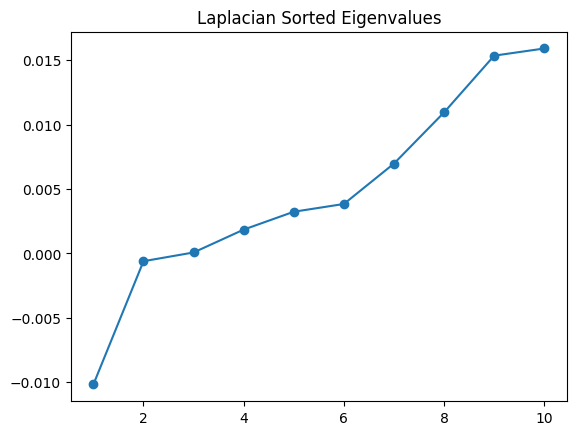

List of eigen values : [0 1 2 3 4 5 6 7]
Threshold choice of eigenvectors : 0.12
Adaptative choice of eigenvectors
Number of cluster selected : 7


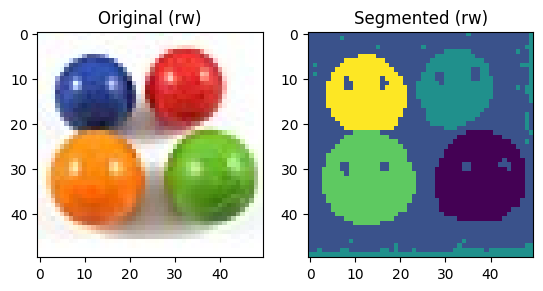

In [42]:
image_segmentation(k=15, laplacian_normalization='rw', num_classes=5, input_img='four_elements.bmp', threshold=0.12, thresh_method='sum')

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

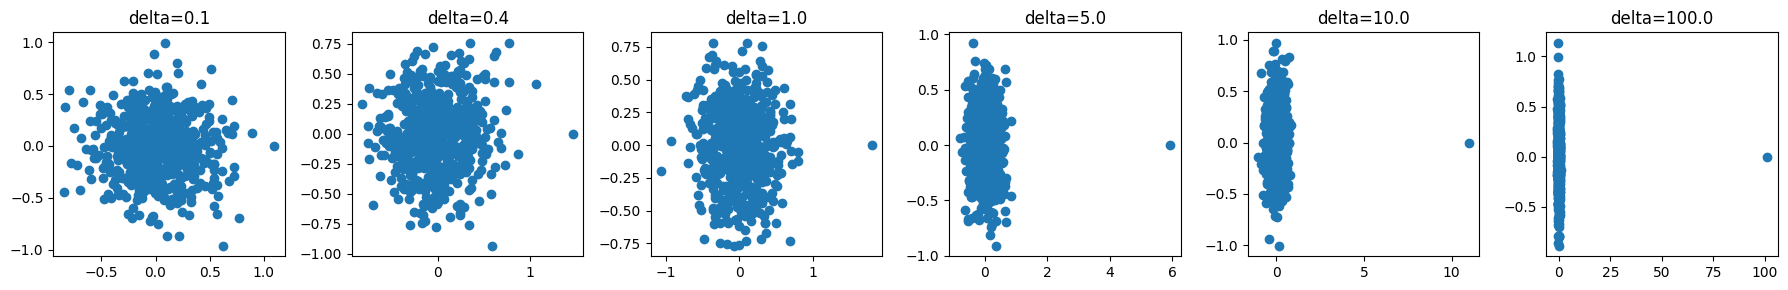

In [18]:
delta_values = [0.1, 0.4, 1.0, 5.0, 10.0, 100.0]

fig, axes = plt.subplots(1, len(delta_values), figsize=(18, 3))

# Generate and plot worst case blobs for deltas values
for ax, delta in zip(axes, delta_values):
    X, Y = worst_case_blob(num_samples=600, delta=delta)
    plot_clusters_fig(X, Y, ax=ax)
    ax.set_title(f'delta={delta}')

plt.tight_layout()
plt.show()

>The function `worst_case_blob` creates one blob cluster with an outlier point that is at a delta-distance from the original cluster border (on the x-axis). Thus, the higher the delta, the farther the outlier is from the cluster, resulting in a more challenging graph representation.


### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

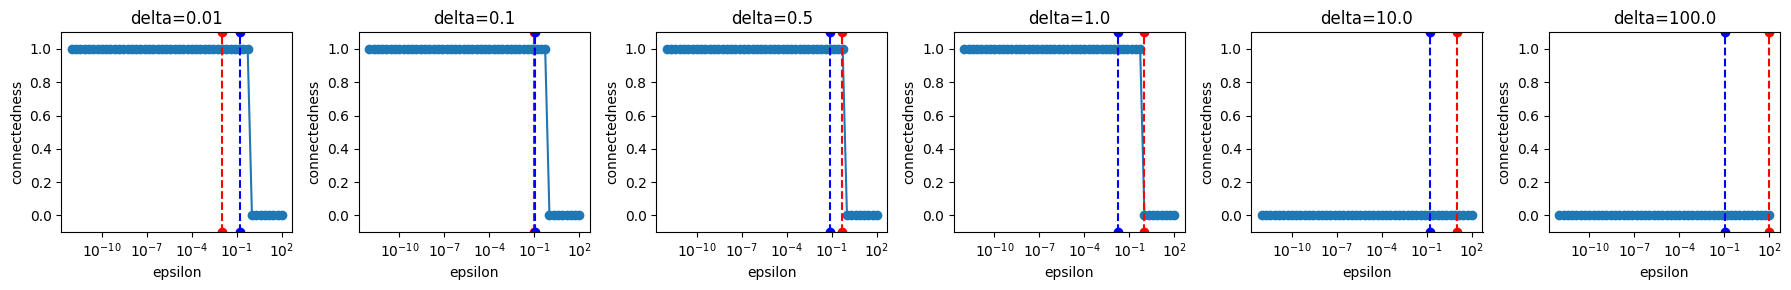

In [89]:
delta_values = [0.01, 0.1, 0.5, 1.0, 10.0, 100.0]
eps_values = np.logspace(-12, 2, 50)  # 50 values by log-scale
blob_var = 0.3

fig, axes = plt.subplots(1, len(delta_values), figsize=(18, 3))

for ax, delta in zip(axes, delta_values):
    connectedness = []
    X, Y = worst_case_blob(num_samples=600, delta=delta)
    
    for eps in eps_values:
        W = build_similarity_graph(X)
        mst = min_span_tree(W)
        eps_connected = np.min(W*mst + np.ones_like(W)-mst)
        W_eps = W*(W>=eps)
        # Check if the graph is connected
        G = nx.from_numpy_array(W_eps)
        if nx.is_connected(G):
            connectedness.append(1)
        else:
            connectedness.append(0)
    
    ax.plot(eps_values, connectedness, marker='o')
    ax.set_xscale('log')
    ax.set_title(f'delta={delta}')
    ax.set_xlabel('epsilon')
    ax.set_ylabel('connectedness')
    ax.set_ylim(-0.1, 1.1)
    ax.axvline(x=delta, color='red', linestyle='--', marker='o')
    ax.axvline(x=eps_connected, color='blue', linestyle='--', marker='o')

plt.tight_layout()
plt.show()


>Red line is `delta`.
<br><br>
>Blue line is $\epsilon_{connected}$.
<br><br>
>By varying the parameter `delta` in `worst_case_blob` and plotting the connectedness of the graph for different values of $\epsilon$, we observe that as `delta` increases, it becomes more challenging to find an $\epsilon$ that keeps the graph connected. For small values of `delta`, a relatively small $\epsilon$ is sufficient to maintain connectedness ($\epsilon\approx 1e-5$). However, it appears that for `delta` above 10 there is no $\epsilon<1e-9$ such that the graph is still connected.
<br><br>
>Using the min span tree $G_T$ we can deduce the $\epsilon_{connected} = min(dist(G_T))$ (for any graph and data distribution) such that the graph is always connected.
<br><br>
>Decreasing $\epsilon$ to face `delta`-increasing is not a proper strategy, the outlier point is `delta`-far from the main cluster, thus the $\epsilon$ required to connect the outlier to the main cluster becomes so important that it will also connect other points that should not be connected. 
<br><br>
>To be more exact, when the maximal distance between two nearest point (which is equal to `delta` in the case of the worst blob with a high `delta`) is higher than any other distance between two points we would need at least a fully connected graph to have a connected graph. We can even compute the maximal $\epsilon_{max}$ value necessary to get the graph of this worst blob connected : $\epsilon_{max}=e^{-\frac{\delta^2}{2\sigma^2}}$.
Therefore, in the peculiar case of `delta`>10, we can't find any $\epsilon$ that will keep the graph connected because the computed value of $\epsilon_{max}$ is approximated as 0 by python resulting in infinite distance (even the min span tree graph is not connected here).

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

>Before anything, we need to justify why is a connected graph important. First of all, in the process of spectral clustering, we aim to take a look at almost zero-valued eigen values and their eigen vectors of the laplacian matrix. But, when a graph is disconnected, the laplacian matrix associated to it is constituated of block laplacian matrix for each connected subgraph. This implies that we have multiple eigen vectors with zero as an eigen values which won't give us further information. Actually, they could mislead our algorithm into thinking that subgraph are cluster. This is not always an issues, but this will often lead to poor results. Therefore, having a connected graph help in reducing this kind of problem (but it is important to note at what cost does we have a connected graph, if the cost is higher than the benefit then connecting-method as the one suggested in Q1.2 won't be more efficient).

In [ ]:
## Adapted plot functions
def plot_graph(X, W, ax=plt, title=''):
    colors = ['go-', 'ro-', 'co-', 'ko-', 'yo-', 'mo-']
    n = len(X)
    G = nx.from_numpy_array(W)
    nx.draw_networkx_edges(G, X, ax=ax)
    for i in range(n):
        ax.plot(X[i, 0], X[i, 1], colors[int(Y[i])])
    ax.set_title(title)
    ax.axis('equal')

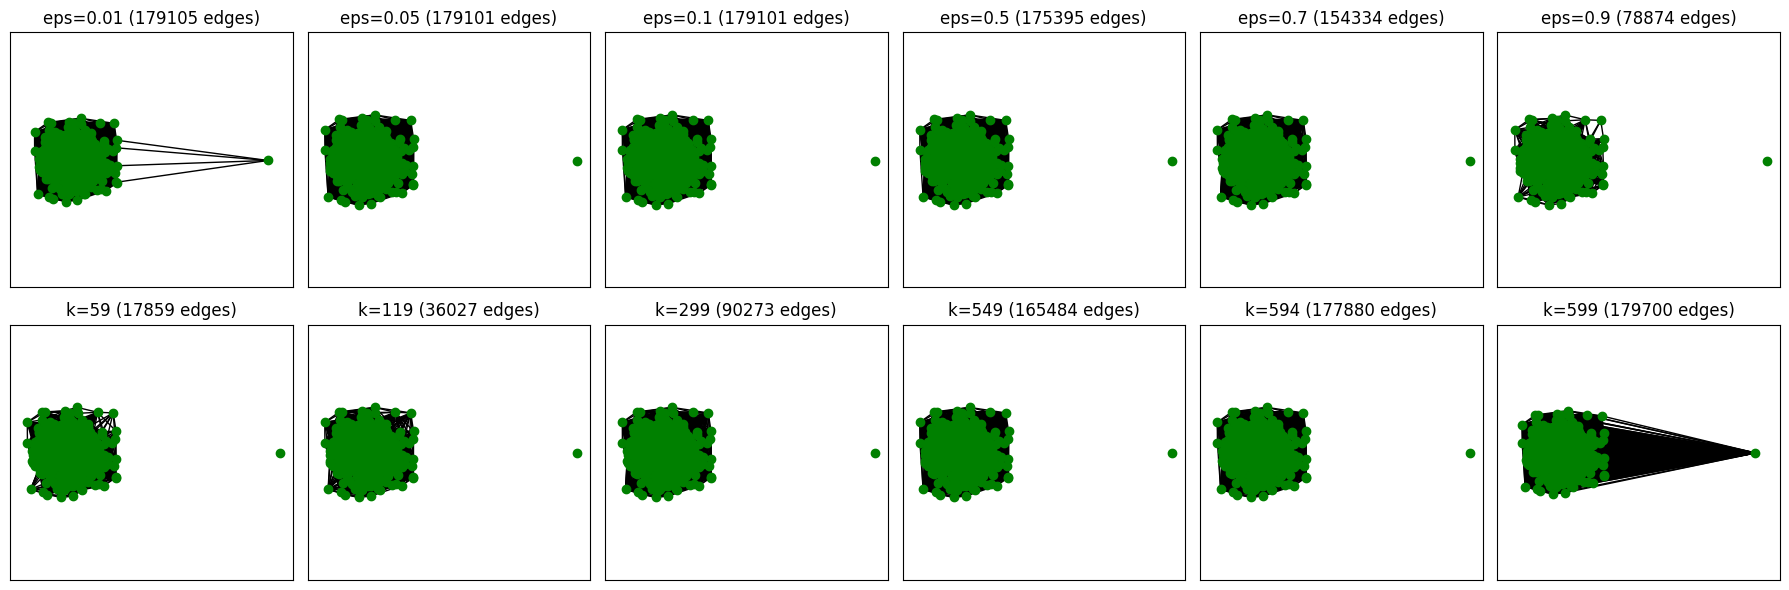

In [25]:
##################### Test on worst blob clustering #####################
X, Y = worst_case_blob(num_samples=600, delta=3.0)
n_element_per_blob = 600-1

eps_values = [0.01, 0.05, 0.1, 0.5, 0.7, 0.9]
k_values = [n_element_per_blob//10, n_element_per_blob//5, n_element_per_blob//2, n_element_per_blob-50, n_element_per_blob-5, n_element_per_blob]

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i, eps in enumerate(eps_values):
    W_eps = build_similarity_graph(X, eps=eps)
    n_edges = np.sum(W_eps>0)//2
    plot_graph(X, W_eps, ax=axes[0, i], title=f'eps={eps} ({n_edges} edges)')

for i, k in enumerate(k_values):
    W_k = build_similarity_graph(X, k=k)
    n_edges = np.sum(W_k>0)//2
    plot_graph(X, W_k, ax=axes[1, i], title=f'k={k} ({n_edges} edges)')

plt.tight_layout()
plt.show()

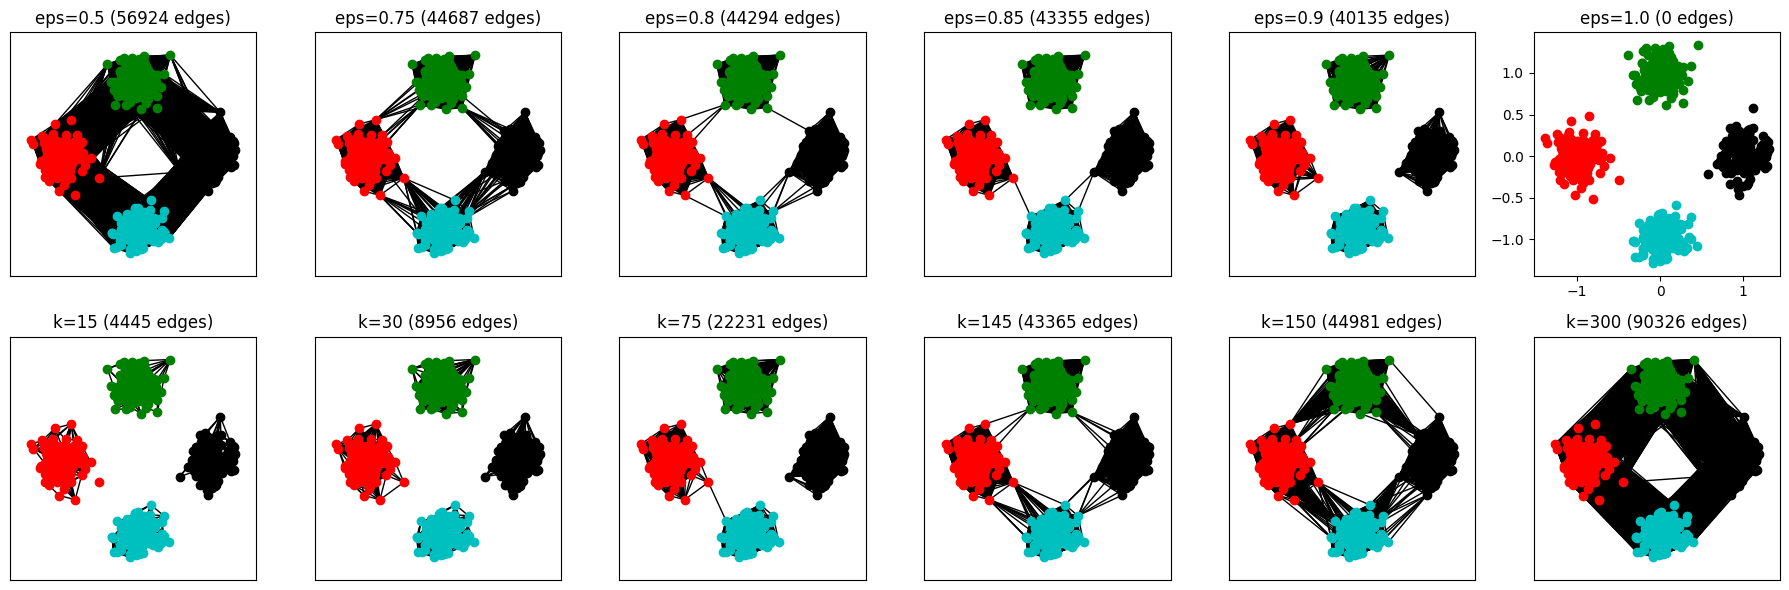

In [20]:
##################### Test on multiple blob clustering #####################
X, Y = blobs(600, n_blobs=4)
n_element_per_blob = 600 // 4

eps_values = [0.5, 0.75, 0.8, 0.85, 0.9, 1.0]
k_values = [n_element_per_blob//10, n_element_per_blob//5, n_element_per_blob//2, n_element_per_blob-5, n_element_per_blob, n_element_per_blob*2]

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i, eps in enumerate(eps_values):
    W_eps = build_similarity_graph(X, eps=eps)
    n_edges = np.sum(W_eps>0)//2
    plot_graph(X, W_eps, ax=axes[0, i], title=f'eps={eps} ({n_edges} edges)')

for i, k in enumerate(k_values):
    W_k = build_similarity_graph(X, k=k)
    n_edges = np.sum(W_k>0)//2
    plot_graph(X, W_k, ax=axes[1, i], title=f'k={k} ({n_edges} edges)')

plt.tight_layout()
plt.show()


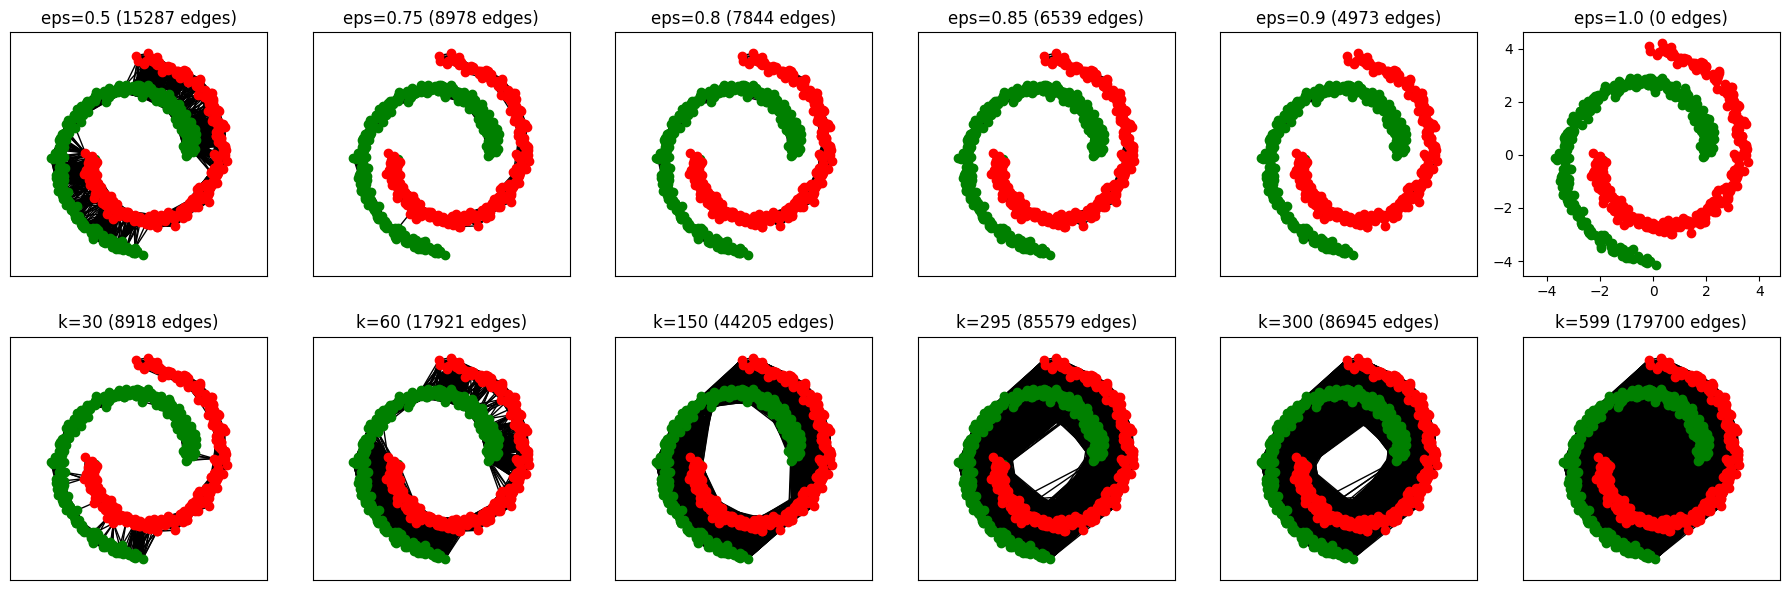

In [27]:
##################### Test on two moons clustering #####################
X, Y = two_moons(600)
n_element_per_blob = 600 // 2

eps_values = [0.5, 0.75, 0.8, 0.85, 0.9, 1.0]
k_values = [n_element_per_blob//10, n_element_per_blob//5, n_element_per_blob//2, n_element_per_blob-5, n_element_per_blob, n_element_per_blob*2-1]

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i, eps in enumerate(eps_values):
    W_eps = build_similarity_graph(X, eps=eps)
    n_edges = np.sum(W_eps>0)//2
    plot_graph(X, W_eps, ax=axes[0, i], title=f'eps={eps} ({n_edges} edges)')

for i, k in enumerate(k_values):
    W_k = build_similarity_graph(X, k=k)
    n_edges = np.sum(W_k>0)//2
    plot_graph(X, W_k, ax=axes[1, i], title=f'k={k} ({n_edges} edges)')

plt.tight_layout()
plt.show()

>Theorically speaking, we can approximately compute the k-NN value such that the graph always stay connected using the following formula : $k_{opt}=max\{k\in\mathbb{N}\,|\; \text{the data contain a k cluster}\}$. 
<br><br>
>But this method is unfortunately extremely data dependant. Which was also the case for the $\epsilon_{opt}$.
<br><br>
>It appears from the above experiments that if our data are highly concentrated for each cluster, then $\epsilon$-graph is more efficient than k-NN. While, if the distance between points (or cluster) is high, then the k-NN is more efficient than $\epsilon$-graph. Indeed, in each of those case, both optimal method reduce the number of edges while keeping the graph connected (which ultimately reduce the complexity of our problem). But in the case that we have highly concentrated data with high distance between cluster (which is the case for the worst blob data), then both method won't be very efficient (We will have to compromise between accurate results or reduced complexity).

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

Is the graph connected?  True
Final k value for connected graph:  300


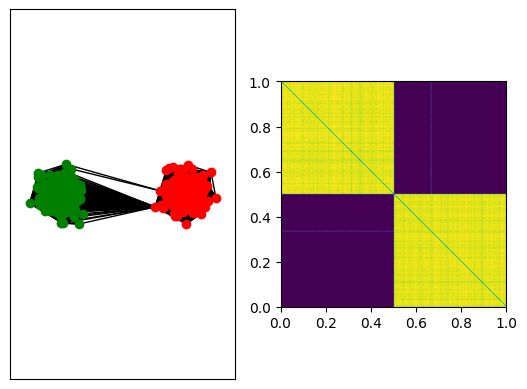

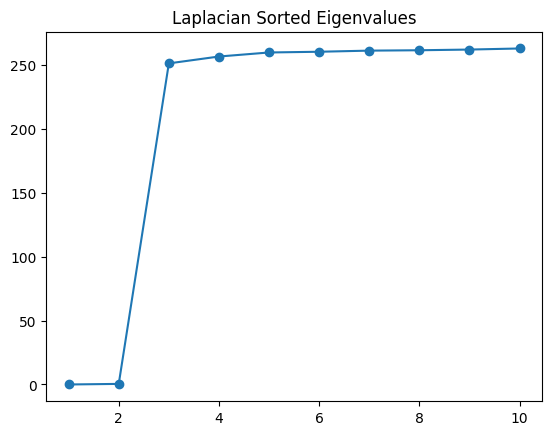

Adaptive choice of eigenvectors
Number of cluster selected : 2


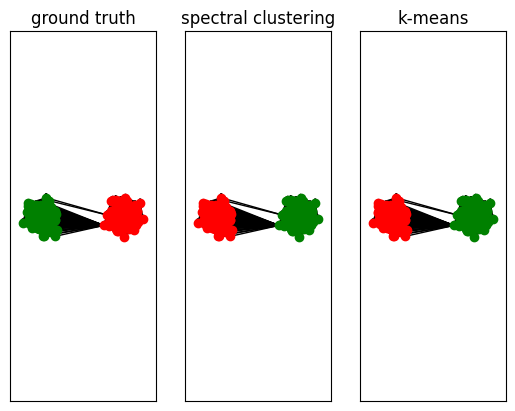

Time to compute spectral clustering:  0.10288214683532715
Time to compute KMeans:  0.001239776611328125


In [55]:
import time
X, Y = blobs(num_samples=600)

# Build a connected graph using k-NN
k = 150 # empirically chosen in the 'while' loop
W = build_similarity_graph(X, k=k)
# test the connectedness of the graph
G = nx.from_numpy_array(W)
while not nx.is_connected(G) and k < 600//2:
    k += 1
    W = build_similarity_graph(X, k=k)
    G = nx.from_numpy_array(W)
print('Is the graph connected? ', nx.is_connected(G))
print('Final k value for connected graph: ', k)
plot_graph_matrix(X, Y, W)

# Laplacian
L = build_laplacian(W)
num_classes = len(np.unique(Y))
# Spectral clustering
_time_ = time.time()
Y_rec = spectral_clustering(L, num_classes=num_classes, verbose=True)
time_sc = time.time()-_time_

# KMeans
_time_ = time.time()
Y_bultin = KMeans(num_classes).fit_predict(X)
time_km = time.time()-_time_

plot_clustering_result(X, Y, L, Y_rec, Y_bultin)

print('Time to compute spectral clustering: ', time_sc)
print('Time to compute KMeans: ', time_km)

>To succesfully buld a connected graph using k-NN we choose empirically $k$ so that the graph is connected. We obtain $k=300$ which is confirming the formula of $k_{connected}$ we gave before.
<br>
>Now, we plan to use spectral clustering to realise a labelling of our data. As the number of classes is $2$, we can use directly use Rayleigh-Ritz theorem to correctly separate the data using the graph. The method work as follow :
<br>
>-Compute the laplacian of the data graph.
<br>
>-Compute the eigenvalues and sort them, only keeping the first two (they should be approximately zero-valued).
<br>
>-The first one is associated to the constant eigen vector $f_1=1_{n}$ while the second eigen vector $f_2$ can be used to cluster the data into two class (based on the sign of each components).
<br>
>   $\quad\quad\quad\text{->}\;class(X_i)=\left\{
\begin{array}{ll}
1 & \text{if } f_2^{(i)}\geq 0 \\
-1 & \text{if } f_2^{(i)}< 0
\end{array}
\right.$
<br>
>What we do in `spectral_clustering` is to generalize this idea : we keep all the eigen vector associated to almost null eigenvalues (the criteria is a bit more complex and will be detailed later), then we cluster using this reduced dimension matrix in a fixed number of classes.
<br>
>As shown by our plot, such a method perfectly worked for our connected graph. Using the built-in k-means we also obtain the same results. But unfortunately, our method is much slower than the built-in k-means.

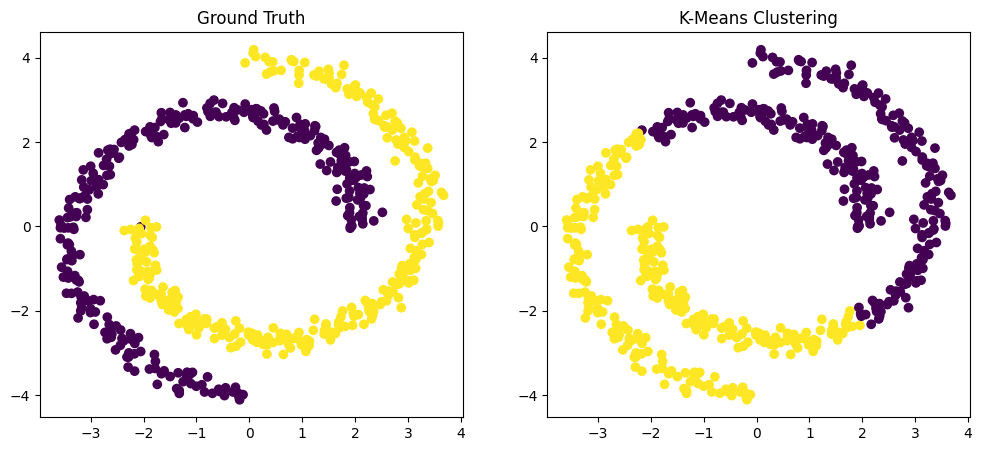

In [80]:
################################### k-means underperform on the two moons data ###################################
X, Y = two_moons(num_samples=600)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters).fit(X)
Y_kmeans = kmeans.labels_
def plot_clustering_result_kmeans(X, Y_true, Y_kmeans):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot ground truth
    axes[0].scatter(X[:, 0], X[:, 1], c=Y_true, cmap='viridis', marker='o')
    axes[0].set_title('Ground Truth')
    
    # Plot k-means result
    axes[1].scatter(X[:, 0], X[:, 1], c=Y_kmeans, cmap='viridis', marker='o')
    axes[1].set_title('K-Means Clustering')
    
    plt.show()

plot_clustering_result_kmeans(X, Y, Y_kmeans)

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

Is the graph connected?  False
Final k value for a non connected graph:  150


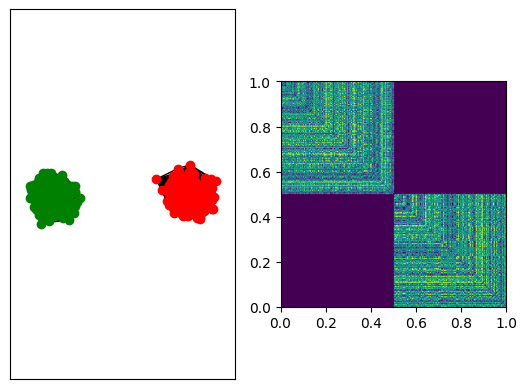

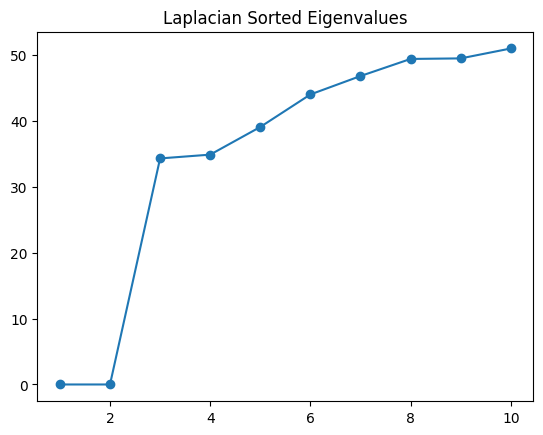

Adaptive choice of eigenvectors
Number of cluster selected : 2


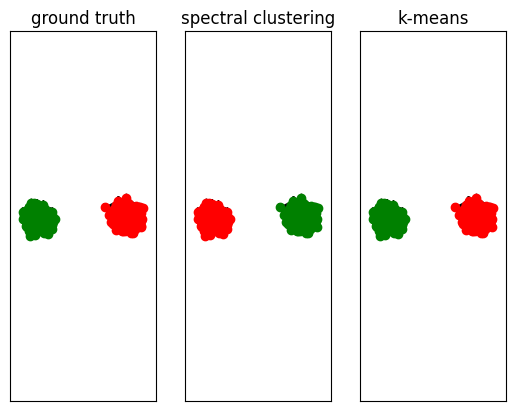

######################################################################
Clustering with chosen eigenvectors : [1 2]


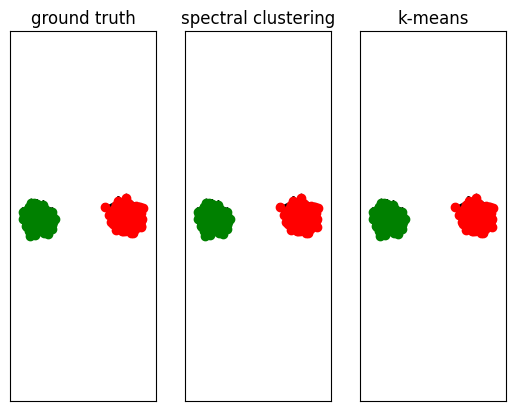

Time to compute spectral clustering:  0.09493517875671387
Time to compute KMeans:  0.0016109943389892578


In [64]:
import time
X, Y = blobs(num_samples=600)

# Build a non connected graph using k-NN
k = 150 # empirically chosen in the 'while' loop
W = build_similarity_graph(X, k=k)
# test the connectedness of the graph
G = nx.from_numpy_array(W)
while nx.is_connected(G) and k > 0: # we want a non connected graph
    k -= 1
    W = build_similarity_graph(X, k=k)
    G = nx.from_numpy_array(W)
print('Is the graph connected? ', nx.is_connected(G))
print('Final k value for a non connected graph: ', k)
plot_graph_matrix(X, Y, W)

# Laplacian
L = build_laplacian(W)
num_classes = len(np.unique(Y))
# Spectral clustering
_time_ = time.time()
Y_rec = spectral_clustering(L, num_classes=num_classes, verbose=True)
time_sc = time.time()-_time_

# Empirical choice of eigenvectors
eigvect = [0,1]
Y_rec_empirical = spectral_clustering(L, num_classes=num_classes, chosen_eig_indices=eigvect)

# KMeans
_time_ = time.time()
Y_bultin = KMeans(num_classes).fit_predict(X)
time_km = time.time()-_time_

plot_clustering_result(X, Y, L, Y_rec, Y_bultin)
print('#'*70)
print('Clustering with chosen eigenvectors : ' + str(np.array(eigvect)+1))
plot_clustering_result(X, Y, L, Y_rec_empirical, Y_bultin)

print('Time to compute spectral clustering: ', time_sc)
print('Time to compute KMeans: ', time_km)

> The difficulty now that we have two separated connected subgraph is that the laplacian is a block matrix for which each block is associated to the subgraph. This is indeed a problem because we now have two "useless" eigen vectors of the laplacian which are a constant one on the first subgraph and a constant one on the second subgraph. Thus, to correctly cluster our data we cannot use the same method as before which would have consisted of only taking the second eigen vector to discriminate. We will need both "first" constant eigen vector. They are both constant on each subgraph, thus by operating a k-means on the matrix constituated of the concatenation of both eigen vector we obtain a proper classification (this is essentially what the adaptative spectrale clustering do when applied on a two classes clustering). 
<br><br>
>To generalize this idea, there is something important to keep in mind : In the case of multiple clusters, taking not enough eigen vectors will always be risked. Indeed, the firsts zero-valued eigen vectors are indeed constant on their subgraph but they are also constant (with a different value) on the rest of the graph, thus they only give us the information to separate between one cluster and the rest. To get the multiple clusters we will need more eigen vectors. This remark will help us later when we will detail how adaptative spectral clustering works.

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

>As the above remark explain, we will need "enough" eigen vectors so that we can correctly separate each cluster. Each eigen vectors is meant to give us information on one peculiar cluster. But taking too much eigen vectors would be a problem because it would be like performing a k-means on the original data, which is not a proper method in many case (refer to the two moons data distribution). In fact, the main idea behind spectral clustering is to correctly grasp the data distribution based on cluster (this is why we need some kind of criteria of proximity to construct the graph). To do so, we realise an embedding into a reduced eigen vectors space (by only keeping "interesting" eigen vectors) on which we operate our classical clustering method. In "A Tutorial on Spectral Clustering" by Ulrike von Luxburg, we learn that a method using the eigen gap (possibly first introduced in "On Spectral Clustering: Analysis and an Algorithm," Andrew Ng, Michael Jordan, and Yair Weiss) help to correctly decide which eigen vectors to keep.
<br><br>
>This is an heuristic method : we need to compute the distance between each eigen values. The highest gap will allow us to separate between "useful" eigen vectors and "useless" ones. We call **adaptative spectral clustering** this eigengap-based method which automatically cluster the data without user empirical chose.
<br><br>
>The exact algorithm work as follow :
<br>
>-Compute the laplacian of the data graph.
<br>
>-Compute the eigenvalues and sort them.
<br>
>-Compute the distance between eigenvalues and found the eigengap (highest distance). Only keep the eigen vectors associated to values before the gap.
<br>
>-Perform a k-means on the new features matrix constituated of the concatenated eigen vectors.

Is the graph connected?  True
Final k value for connected graph:  150


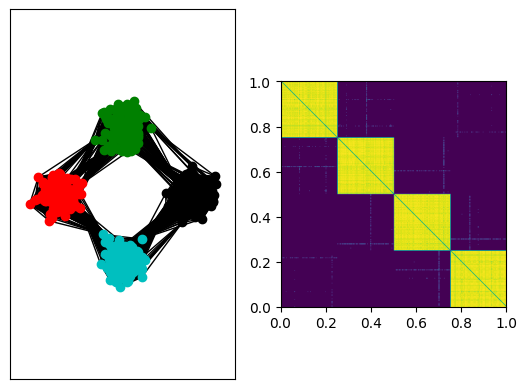

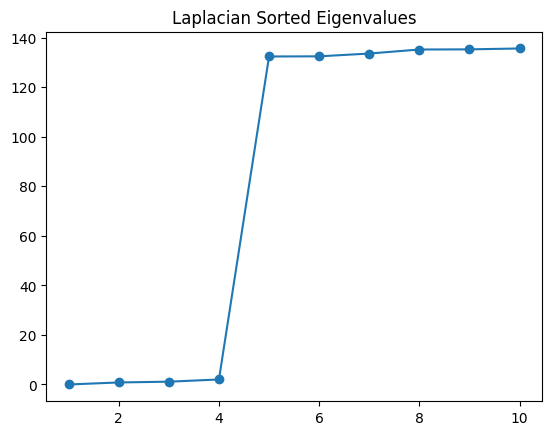

Adaptative choice of eigenvectors
Number of cluster selected : 4


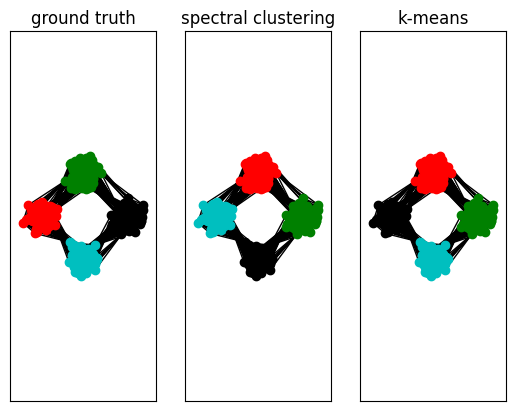

In [194]:
########################################## Test adaptative spectral clustering on 4 classical blobs ##########################################
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
# Build a connected graph using k-NN
k = 150  # empirically chosen
W = build_similarity_graph(X, k=k)
G = nx.from_numpy_array(W)
while not nx.is_connected(G) and k < 600 // 2:
    k += 1
    W = build_similarity_graph(X, k=k)
    G = nx.from_numpy_array(W)
print('Is the graph connected? ', nx.is_connected(G))
print('Final k value for connected graph: ', k)
plot_graph_matrix(X, Y, W)

# Laplacian
L = build_laplacian(W)
num_classes = len(np.unique(Y))

# Spectral clustering
Y_rec = spectral_clustering(L, num_classes=num_classes, verbose=True)

# Plot results
plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

######################################################################
Clustering with adaptative choice of eigenvectors with blob variance: 0.1
Is the graph connected?  True
Final k value for connected graph:  150


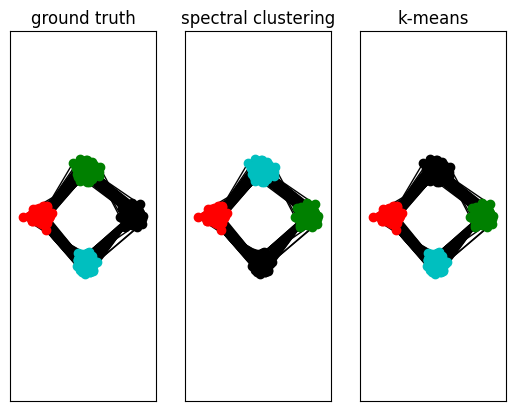

######################################################################
Clustering with adaptative choice of eigenvectors with blob variance: 0.5
Is the graph connected?  True
Final k value for connected graph:  150


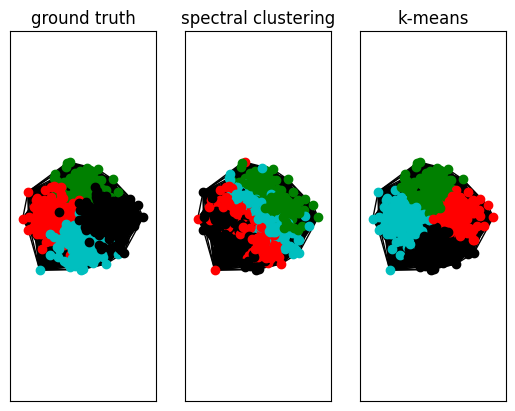

######################################################################
Clustering with adaptative choice of eigenvectors with blob variance: 1.0
Is the graph connected?  True
Final k value for connected graph:  150


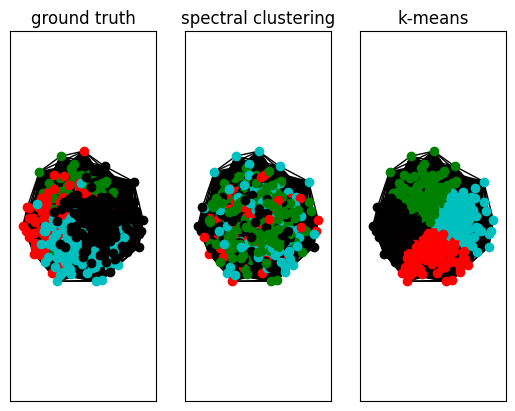

######################################################################
Clustering with adaptative choice of eigenvectors with blob variance: 5.0
Is the graph connected?  True
Final k value for connected graph:  150


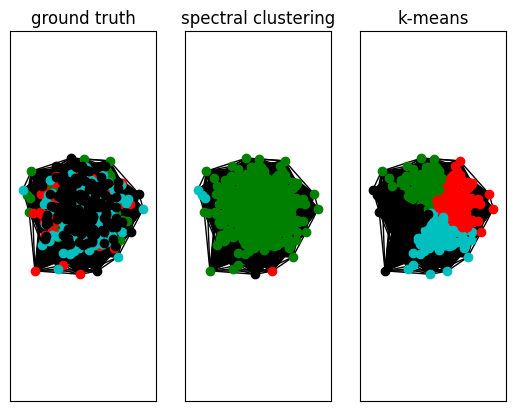

In [195]:
################################### Moving blobs variance ###################################
for var in [0.1, 0.5, 1.0, 5.0]:
    print('#'*70)
    print('Clustering with adaptative choice of eigenvectors with blob variance: ' + str(var))
    X, Y = blobs(num_samples=600, n_blobs=4, blob_var=var)
    # Build a connected graph using k-NN
    k = 150  # empirically chosen
    W = build_similarity_graph(X, k=k)
    G = nx.from_numpy_array(W)
    while not nx.is_connected(G) and k < 600 // 2:
        k += 1
        W = build_similarity_graph(X, k=k)
        G = nx.from_numpy_array(W)
    print('Is the graph connected? ', nx.is_connected(G))
    print('Final k value for connected graph: ', k)

    # Laplacian
    L = build_laplacian(W)
    num_classes = len(np.unique(Y))

    # Spectral clustering
    Y_rec = spectral_clustering(L, num_classes=num_classes)

    # Plot results
    plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

>When the variance of the blobs increased the clusters begin to partially fuse resulting on difficult classification. As the above plots show, adaptative spectral clustering become inefficcient.

>But unfortunately the adaptative spectral clustering detailed above is not complete. Indeed we could have a problem if there is a high eigengap between eigenvalues which are of no interest to us (with a value greatly above zero). Let see this using the two moons data distribution :

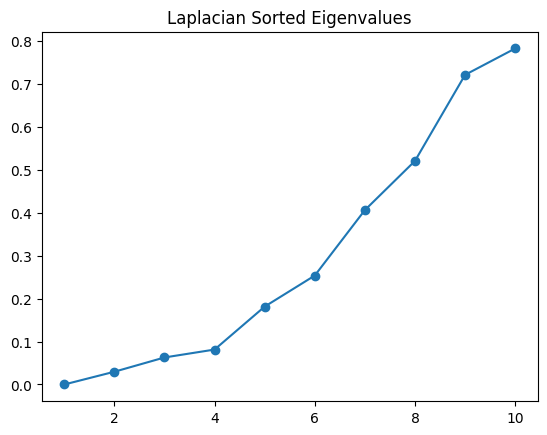

Adaptative choice of eigenvectors
Number of cluster selected : 8


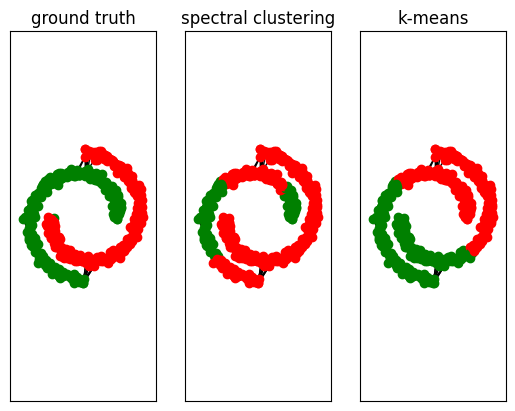

In [197]:
X, Y = two_moons(num_samples=600)
num_classes = 2
W = build_similarity_graph(X, k=20)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, verbose=True)

plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

>Using the two moons data distribution we observe that the graph laplacian eigen values are smoothily decreasing to non-zero value. Which then result in a wrong eigen value selection. This is indeed a problem, as the final spectral clustering result shows it : The second class has spread on the first one cluster. This results in wrong classification. We will later call this phenomenum "class spreading" because we can see that the wrong class has spread on the other cluster along the graph.
<br><br>
>To address this, we need to change a bit the computation process. Now, we compute using the same method but we suppress the eigenvalues that are too far from zero using some threshold (it means that we search the eigengap between almost-zero eigen values, the precision depend on the threshold chosen) :

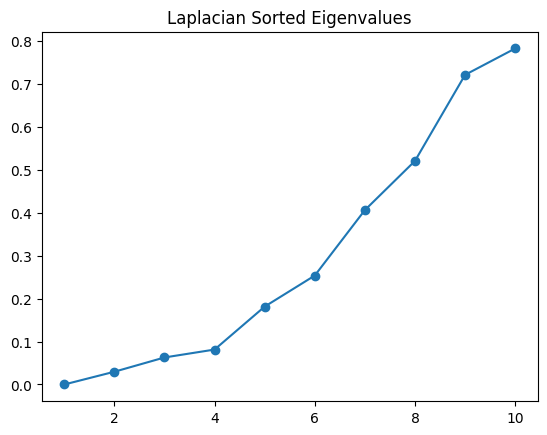

List of eigen values : [0 1 2 3]
Threshold choice of eigenvectors : 0.1
Adaptative choice of eigenvectors
Number of cluster selected : 3


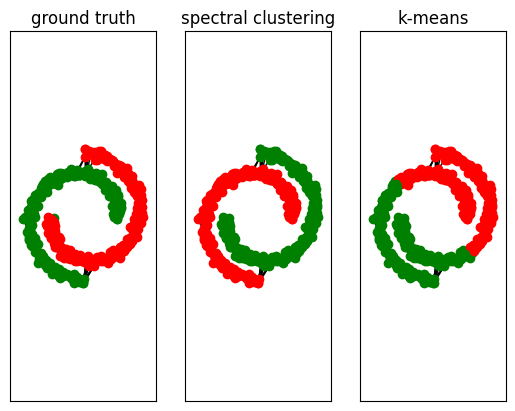

In [202]:
num_classes = 2
W = build_similarity_graph(X, k=20)
L = build_laplacian(W)
# threshold is the parameter to choose the maximal value we accept for the eigenvalues
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, threshold=0.1, verbose=True)

plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

>Empirically speaking it appears that a threshold between $0.05$ and $0.1$ is sufficient to solve most "class spreading" observed (refer to later experiment made on the point and circle data distribution).
<br><br>
>This method solves correctly the classification here but to be completely honest, even this method is not perfect. I invite you to compute the above cell multiple time and you will see that sometimes we still have an unproper classification.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

>**WARNING**: the thresholding mentioned here is not the same as the one mentioned in Q2.3. Indeed, in  this question (Q2.4) we are speaking about replacing k-means (for cluster assignment) by a threshold method on the values of the eigen vectors. **While** the thresholding I speak about in Q2.3 only consist on keeping all the eigen vectors associated to eigenvalues $\lambda_i<threshold$ and then perform on those the automatic eigengap computation method. Finally, when the number of eigen values to keep has been decided using the eigen gap, we still use k-means to do cluster assignment.
<br><br>
>So far, the last step of the spectral clustering as always be k-means. In some small instances, thresholding is easy to use and to interprete but for higher classification problem k-means is a better solution. And thresholding is highly dependant of the data distribution which is less the case of k-means. Indeed, while thresholding give us a space division to identify class, k-means try to group together similarly embedded data. 
<br><br>
>Thus, I would recommend thresholding for smaller instances of classification problems and k-means for the rest (in any case k-means always perform as well as thresholding, thus we will only be using it). It is important to understand that thresholding method is highly dependant on the data distribution the more complex it is the less efficient will thresholding be, while k-means is not perfect, it yields better results in more complec cases.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

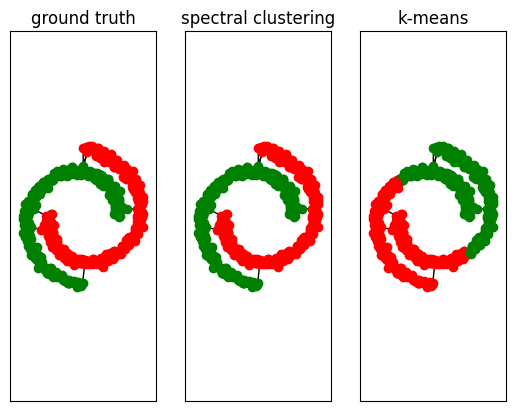

In [204]:
X, Y = two_moons(num_samples=600)
num_classes = 2
W = build_similarity_graph(X, k=20)
L = build_laplacian(W)
# threshold is the parameter to choose the maximal value we accept for the eigenvalues (empirical choice)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, threshold=0.1) # , verbose=True

plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

>We observe that while the spectral clustering manage to correctly class these data distribution, k-means do not. To be more accurante, it appears that k-means has classified the data without grasping their peculiar structure.
<br><br>
>To understand why, we need to dive more into k-means. The main idea of unsupervised k-means is to minimize an objective function : 
<br><br>
> $\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad J = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2 $
<br><br>
>where:
<br>
>-$k$ is the number of classes searched,
<br>
>-$C_i$ is the set of points in cluster $i$ (associated to class $i$),
<br>
>-$\mu_i$ is the centroid of cluster $i$,
<br>
>-$x$ is a data point.
<br><br>
>This explain ultimately why we obtain such a graph. Classical k-means has computed two cluster of proximal data (with respect to euclidean norm). It did not care for their peculiar structure. Such a phenomenum justify the use of graph embedding to solve clustering problems, because these methods manage to grasp the underlying manifold of the data distribution.
<br><br>
>The graph structure give us some hint on what happened for the k-means to perform so poorly : as we can see, the two parts which are linked in the graph have been clustered together.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

>Before anything, let us test what happen when we don't use the thresholding suggested at the end of Q2.3 to reduce the number of eigen values.

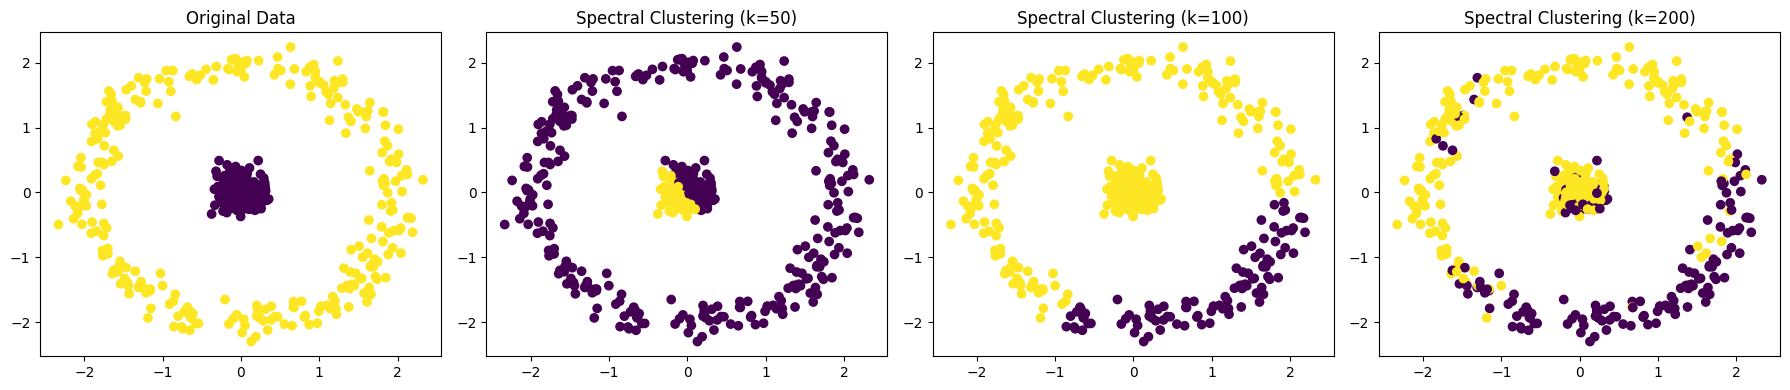

In [12]:
######## WITHOUT THRESHOLD ########
X, Y = point_and_circle(num_samples=600)
num_classes = 2
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for i, k in enumerate([25, 50, 100, 200]):
    W = build_similarity_graph(X, k=k)

    # Unnormalized Laplacian
    L_unn = build_laplacian(W, laplacian_normalization='unn')

    Y_rec_unn = spectral_clustering(L_unn, num_classes=num_classes, threshold=None)

    if i == 0:
        # Original data
        axes[i].scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', marker='o')
        axes[i].set_title('Original Data')
    else:
        axes[i].scatter(X[:, 0], X[:, 1], c=Y_rec_unn, cmap='viridis', marker='o')
        axes[i].set_title(f'Spectral Clustering (k={k})')

plt.tight_layout()
plt.show()


>As you can see, we observe the same phenomenum that the one in Q2.3 which we called "class spreading". To solve this and have a proper working adaptative spectral clustering, we indeed need a threshold on the eigen values to keep. Thus we now conduct our experiments with $threshold = 0.05$. Now, see the comparison between the different laplacian building method :

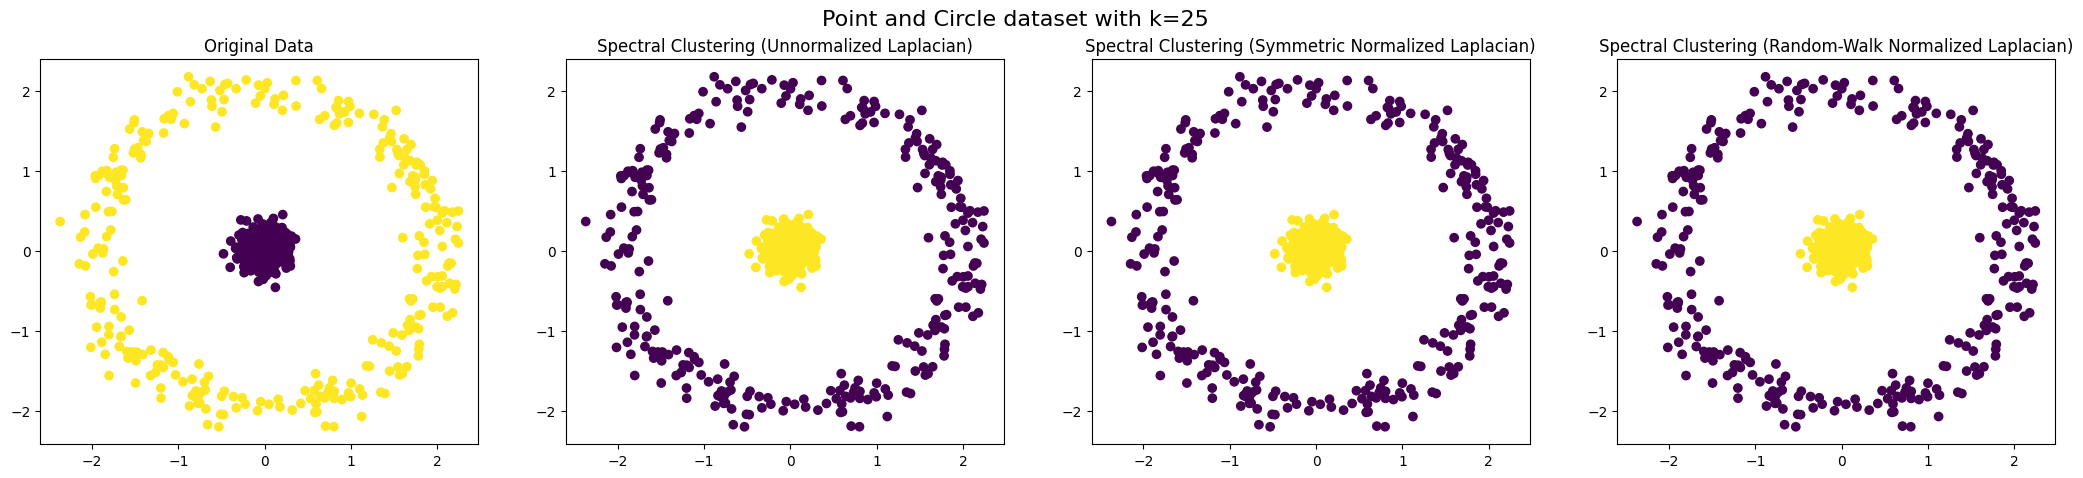

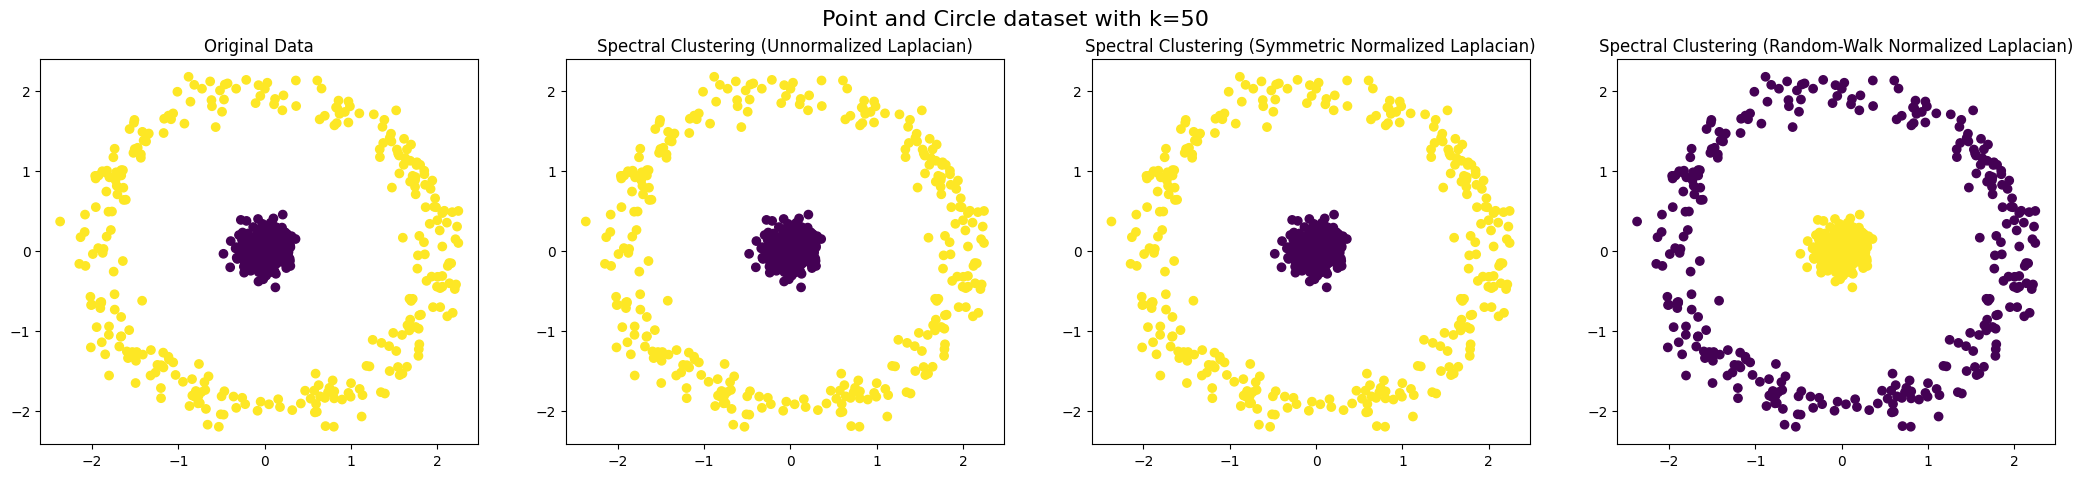

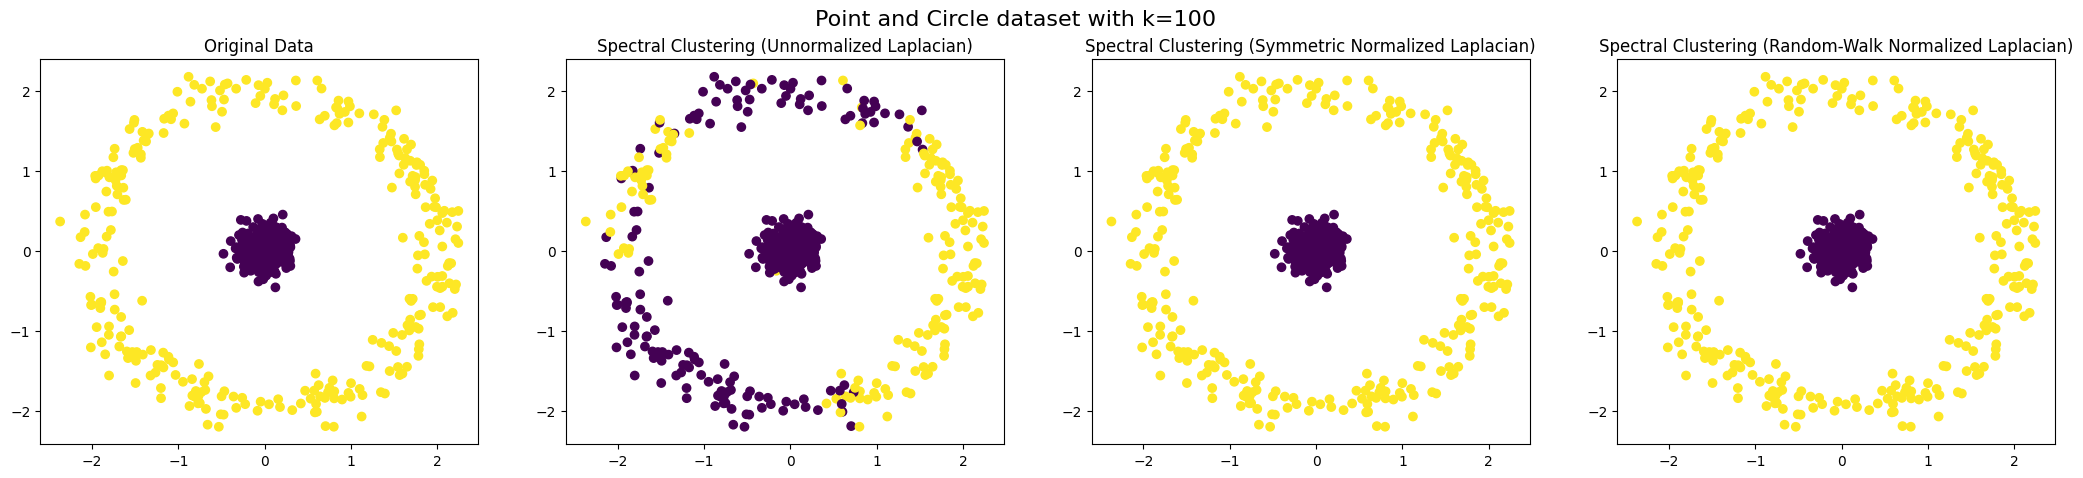

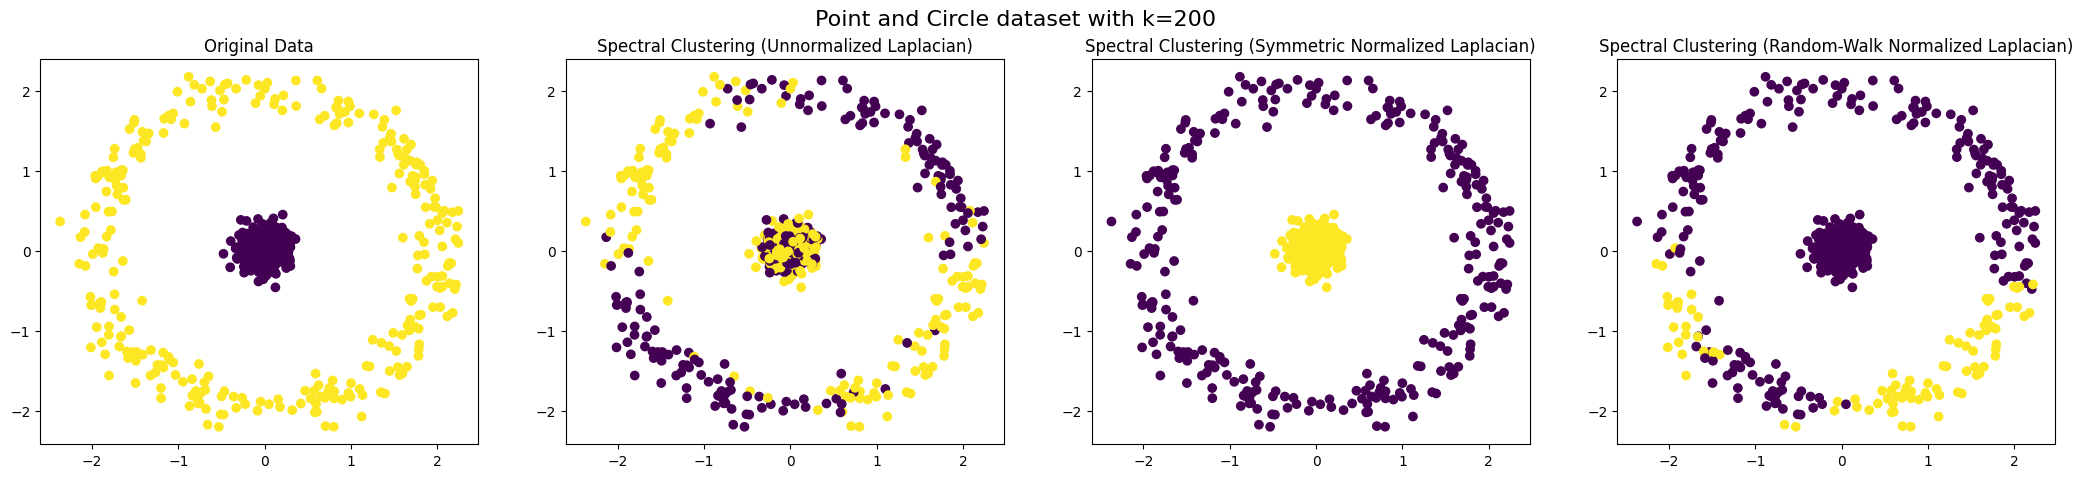

In [224]:
X, Y = point_and_circle(num_samples=600)
num_classes = 2
for k in [25, 50, 100, 200]:
    W = build_similarity_graph(X, k=k)

    # Unnormalized Laplacian
    L_unn = build_laplacian(W, laplacian_normalization='unn')

    # Symetric normalized Laplacian
    L_sym = build_laplacian(W, laplacian_normalization='sym')

    # Random-walk normalized Laplacian
    L_rw = build_laplacian(W, laplacian_normalization='rw')

    num_classes = len(np.unique(Y))
    Y_rec_unn = spectral_clustering(L_unn, num_classes=num_classes, threshold=0.05)
    Y_rec_sym = spectral_clustering(L_sym, num_classes=num_classes, threshold=0.05)
    Y_rec_rw = spectral_clustering(L_rw, num_classes=num_classes, threshold=0.05)

    fig, axes = plt.subplots(1, 4, figsize=(26, 5))
    fig.suptitle(f'Point and Circle dataset with k={k}', fontsize=16)
    # Original data
    axes[0].scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', marker='o')
    axes[0].set_title('Original Data')

    axes[1].scatter(X[:, 0], X[:, 1], c=Y_rec_unn, cmap='viridis', marker='o')
    axes[1].set_title('Spectral Clustering (Unnormalized Laplacian)')

    axes[2].scatter(X[:, 0], X[:, 1], c=Y_rec_sym, cmap='viridis', marker='o')
    axes[2].set_title('Spectral Clustering (Symmetric Normalized Laplacian)')

    axes[3].scatter(X[:, 0], X[:, 1], c=Y_rec_rw, cmap='viridis', marker='o')
    axes[3].set_title('Spectral Clustering (Random-Walk Normalized Laplacian)')

>The first remark we can make is that by thresholding on the eigen values (keeping only the near zero eigen values), we don't have "class spreading" for $k\leq50$. 
<br><br>
> We also observe that all three method to compute the laplacian yield good results for $k$ values small enough (which is because each border data points is not highly linked to the center data points). But when we increase $k$, the first method to become less efficient is the normal laplacian based one. Finally, we do also observe that symmetric normalized laplacian always give us proper classification.
<br><br>
>Theoretically speaking, this could be explained by the problem we are trying to solve using both method. Indeed, spectral clustering with unnormalized laplacian is an approximation of the $RatioCut$ problem. While the two other normalized laplacian are approximation to $NCut$ problem.
<br><br>
>For a cut between two set of point $A$ and $B$, the objectives functions of both problem can be computed as follow :
<br>
>$\quad\quad\quad\quad\quad\quad\quad\quad \text{-> RatioCut}(A,B)=cut(A,B)\left(\frac{1}{|A|}+\frac{1}{|B|}\right)$
<br>
>$\quad\quad\quad\quad\quad\quad\quad\quad \text{-> NCut}(A,B)=cut(A,B)\left(\frac{1}{vol(A)}+\frac{1}{vol(B)}\right)$
<br><br>
>Where the volume of $A$ is the sum of vertices degrees in $A$.
<br><br>
>Now that we have said that, the fact that normalized laplacian methods outperform unnormalized method can be explained by the data structure. Recall that the weight of our graph edges used in the volume computation are based on the similarities between data point. Thus, $RatioCut$ try to keep equal the number of element in both set and $NCut$ try to keep the similarities summed together equal between both cluster. While this would not be a problem if we computed perfectly the optimal solution, as spectral clustering are both approximation method, during the process of solving $RatioCut$ it is possible that we will be stuck on a local minimum where both set cardinal are approximately equal. In comparison, if we use approximated $NCut$ methods then if one of the cluster contain some data from the point and also from the circle it would lead to higher unbalanced value of their volume. Thus, explaining why normalized laplacian here have shown better results.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

>For our method involving thresholding presented in Q2.3, we have suggested empirically based threshold for a k-NN graph. But we also need to conduct similar test for $\epsilon$-graph :

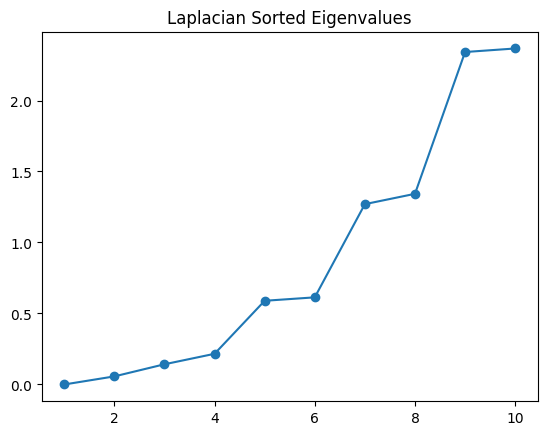

List of eigen values : [0 1 2 3]
Threshold choice of eigenvectors : 0.05
Adaptative choice of eigenvectors
Number of cluster selected : 3


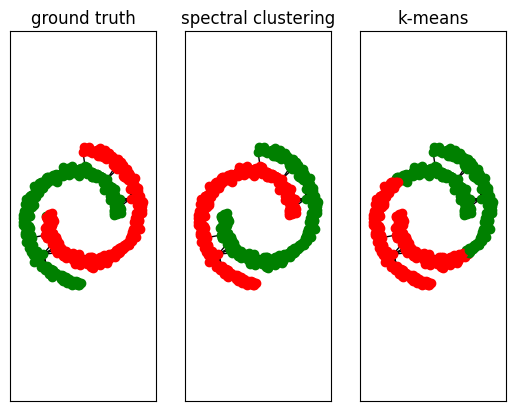

In [266]:
###################################### Test on two moons clustering to find optimal threshold for epsilon-graph ######################################
X, Y = two_moons(num_samples=600)

eps = 0.7

W_eps = build_similarity_graph(X, eps=eps)

L_eps = build_laplacian(W_eps)

num_classes = len(np.unique(Y))
Y_rec_eps = spectral_clustering(L_eps, num_classes=num_classes, threshold=0.05, verbose=True)

plot_clustering_result(X, Y, W_eps, Y_rec_eps, KMeans(num_classes).fit_predict(X))

>First of all to realise a proper and thorough experiment on the parameter sensibility we need to test different adaptive selection methods. Indeed, it may be possible that one is highly sensitive while a more optimal one would be less sensitive.
<br><br>
>Thus, the first method we test is the classic eigengap based method (without any reduction on the eigen vectors space).

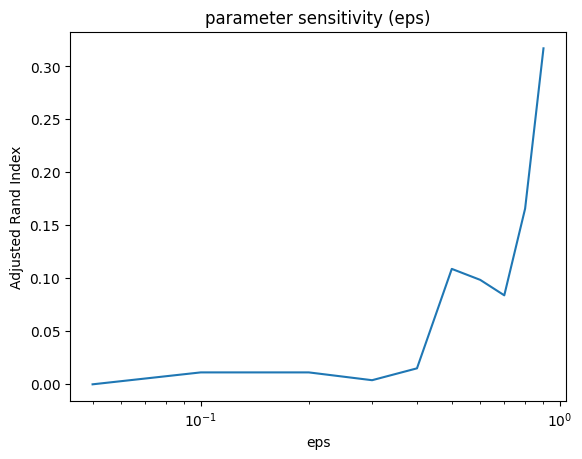

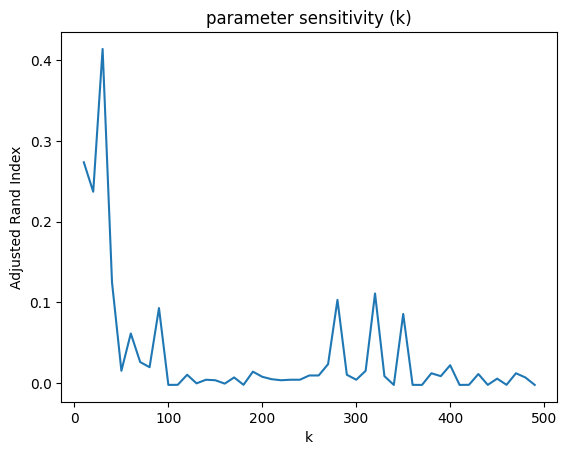

In [24]:
# Sensitivity analysis for epsilon parameter
eps_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#np.logspace(-2, 0, 10)  
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=None, parameter_type='eps', parameter_candidate=eps_values)

# Sensitivity analysis for k parameter
k_values = np.arange(10, 500, 10)
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=None, parameter_type='k', parameter_candidate=k_values)

>We observe that such a method does not yield good results. Indeed, even if we chose carefully its parameters it appears that we won't be able to correctly classify our two moons dataset. This confirm the observation so far that some eigen values interfere with the spectral clustering. 

>Now, we want to test the method that we used for most of the complex distribution we classified before : The eigen space reduction method, which reduces the eigen vectors that we will compare to compute the highest eigen gap (Recall that the main idea is that we want to only keep near zero eigen values). 

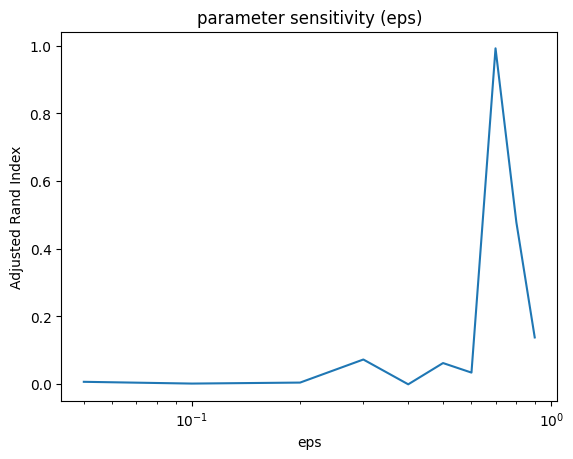

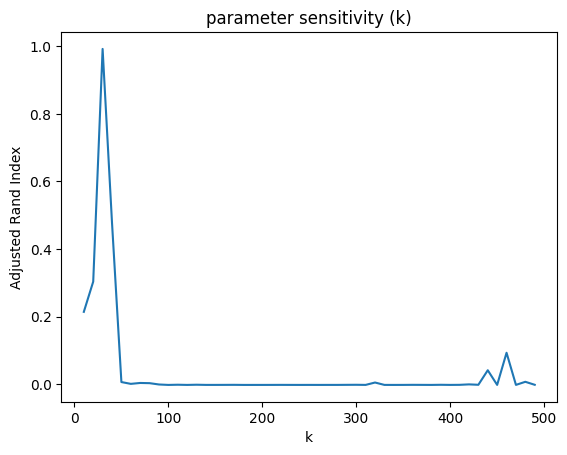

In [268]:
# Sensitivity analysis for epsilon parameter
eps_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#np.logspace(-2, 0, 10)  
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=None, parameter_type='eps', parameter_candidate=eps_values, threshold=0.05, thresh_method='sum')

# Sensitivity analysis for k parameter
k_values = np.arange(10, 500, 10)
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=None, parameter_type='k', parameter_candidate=k_values, threshold=0.1, thresh_method='sum')

>We observe that adaptive spectral clustering sensitivity is high. Indeed, both curves appears to attain a perfect accuracy only around some values. This is mostly due to the fact tha we perform here spectral clustering on the moon data distribution (which is harder to clusterize) but this shows us that such a spectral clustering is still highly dependant on the data distribution.

>Now, we want to test another eigen space reduction method. This one will proceed as follow : First compute the gap between all eigen values, then take the first gap which is above a given threshold and finally, only keep the eigen vectors associated to eigen values before the gap (the one from the gap are included).

/tmp/ipykernel_1147/1359328407.py:51: RuntimeWarning: invalid value encountered in divide
  E /= np.sum(E)


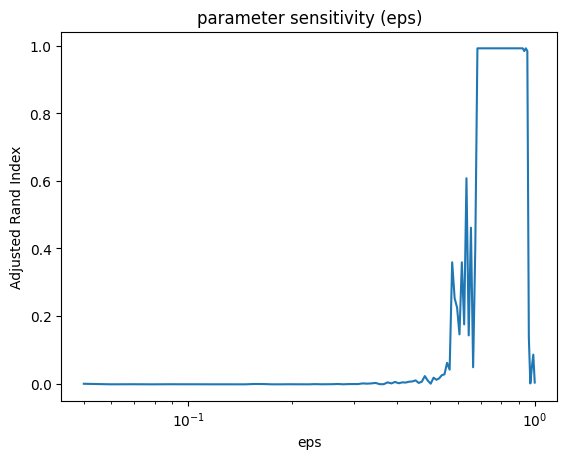

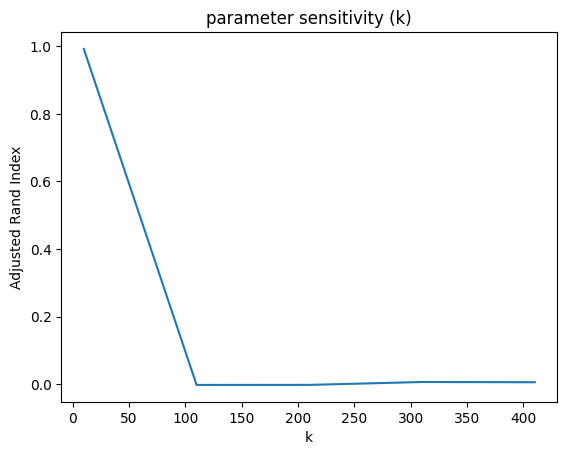

In [ ]:
# Sensitivity analysis for epsilon parameter
eps_values = np.linspace(0.05,1,100) #np.logspace(-2, 0, 10)  
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=None, parameter_type='eps', parameter_candidate=eps_values, threshold=0.2, thresh_method='diff')

# Sensitivity analysis for k parameter
k_values = np.arange(10, 500, 100)
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=None, parameter_type='k', parameter_candidate=k_values, threshold=0.2, thresh_method='diff')

>From both experiment that we conducted on adaptive spectral clustering, we observe that such a method sensitivity is high. This implies that we will need empiricaly chose the parameter. Eventually, this means that either we will need to have access to the ground true labels or we will need to have an operator monitoring the results (either a human or a metric based algorithm).

>To complete this experimentation, we will test spectral clustering sensitivity on chosen eigen vectors (with no adaptive process). We can approximately decide on which eigen vectors to keep based on the fact that we clusterize here the two moon data distribution.

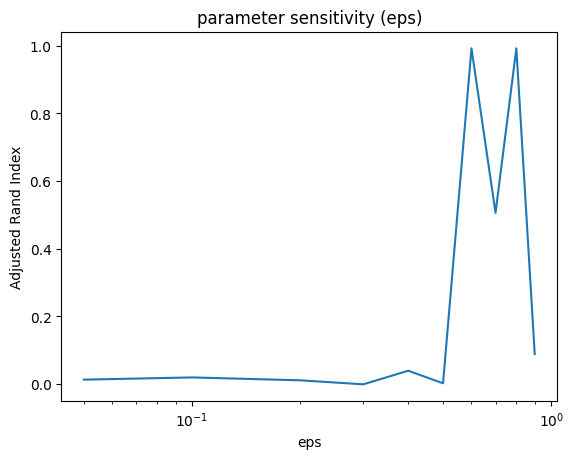

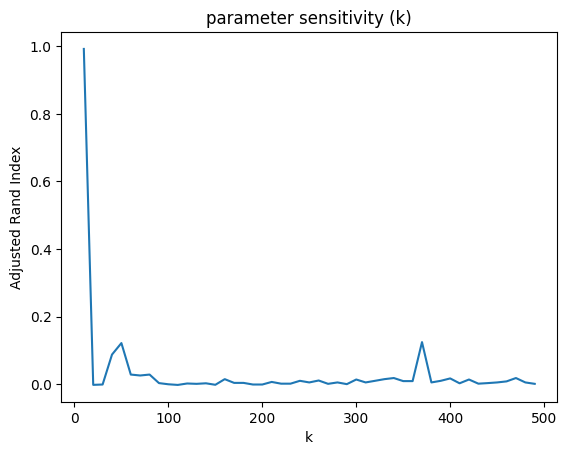

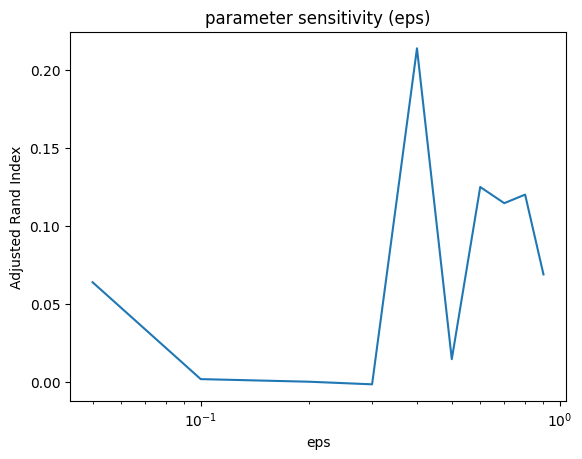

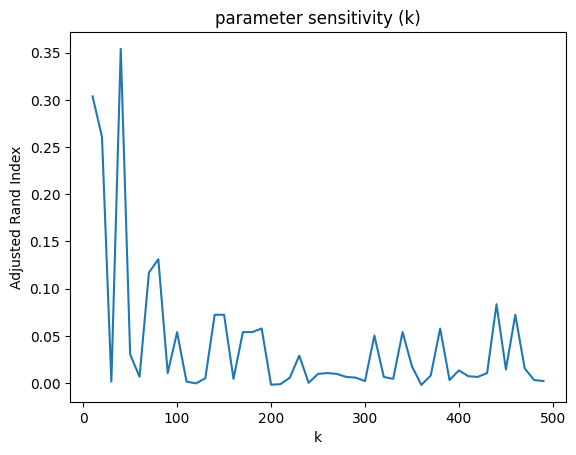

In [36]:
## With chosen eigenvectors : [0,1,2] 
# Sensitivity analysis for epsilon parameter
eps_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#np.logspace(-2, 0, 10)  
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=[0,1,2], parameter_type='eps', parameter_candidate=eps_values)

# Sensitivity analysis for k parameter
k_values = np.arange(10, 500, 10)
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=[0,1,2], parameter_type='k', parameter_candidate=k_values)


## With chosen eigenvectors : [1,2,3] 
# Sensitivity analysis for epsilon parameter
eps_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#np.logspace(-2, 0, 10)  
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=[1,2,3], parameter_type='eps', parameter_candidate=eps_values)

# Sensitivity analysis for k parameter
k_values = np.arange(10, 500, 10)
parameter_sensitivity(num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=[1,2,3], parameter_type='k', parameter_candidate=k_values)

> It appears that the sensitivity of spectral clustering is not due to the adaptive process but more of a inner phenomenum. This confirm that we will either need to know the true label or to have a way to discriminate between proper and unproper clustering.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

>To correctly monitor our results, we would need to use a metric capable of identifying if a partition of a graph correctly clusterize its nodes. In "Finding and evaluating community structure in networks." by Newman, M. E. J. and Girvan, M.; the authors introduced the *modularity measure*. To compute this metric, they introduced the following formula :
<br><br>
>$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad \text{-> }Q = \frac{1}{2m} \sum_{u,v} \left( W_{uv} - \frac{k_u k_v}{2m} \right) \delta(c_u, c_v)$
<br><br>
>Where:
<br>
>-$W_{ij}$: Same weight matrix.
>- $k_u, k_v $: Degrees of nodes $u$ and $v$ (In our peculiar case, it is computed as a sum of neighboor weight).
>- $m$: Total number of edges in the graph.
>- $\delta(c_u, c_v) = \left\{
\begin{array}{ll}
1 & \text{if \(u\) and \(v\) are in the same community} \\
0 & \text{otherwise }
\end{array}
\right.$


>We can easily compute it using $networkx$ package.
<br><br>
>Let us divide this experiment in two : first we will test in the case of spectral clustering parameter leading to bad results (based on Q2.7) and then we will test on optimal parameter for performance.

Modularity: 0.497983431550998


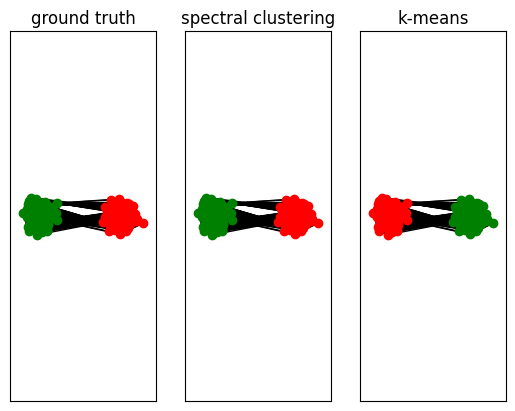

Modularity: 0.3872481563406649


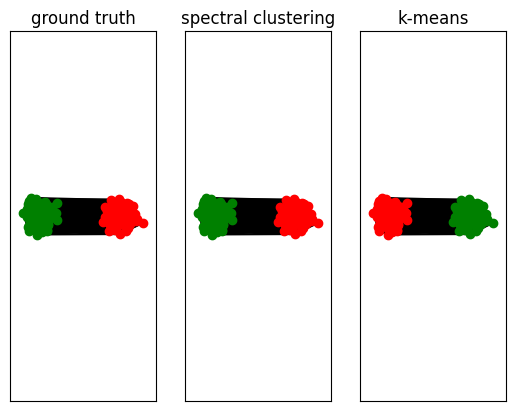

Modularity: 0.22527337878140177


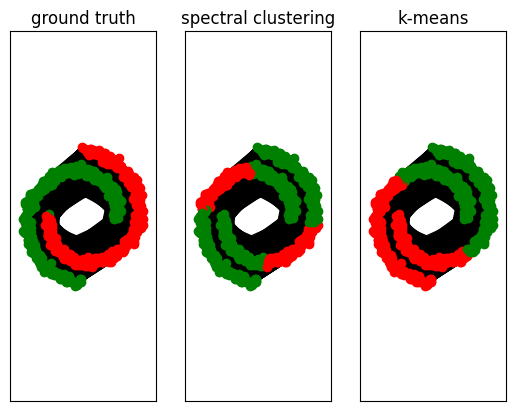

Modularity: 0.3333305285461167


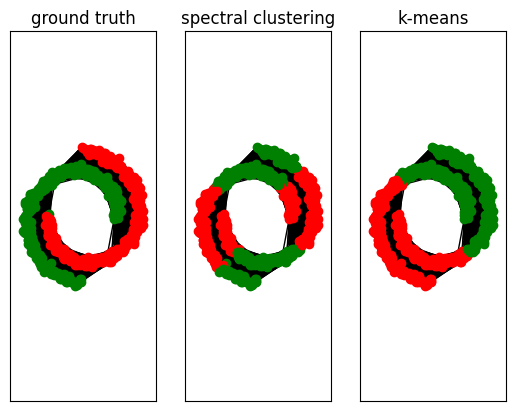

Modularity: 0.00765970916569797


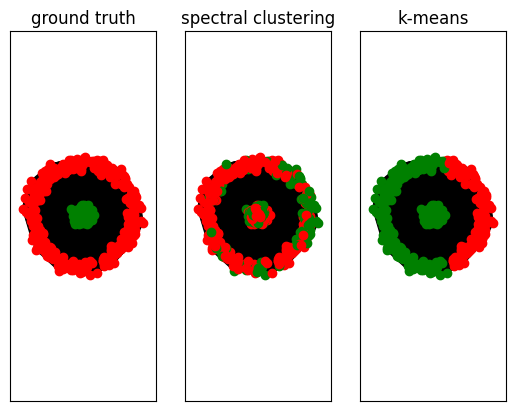

Modularity: 0.01613330421383838


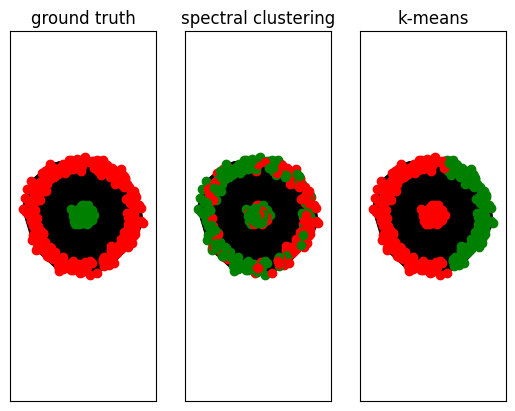

In [12]:
import networkx as nx

################################################ Worst case ########################################################

for func in [blobs, two_moons, point_and_circle]:
    X, Y_true = func(num_samples=600)

####################################### Test for k-NN ########################################################

    # Build a connected graph using k-NN
    k = 300  # empirically chosen
    W = build_similarity_graph(X, k=k)
    G = nx.from_numpy_array(W)

    # Laplacian
    L = build_laplacian(W)
    num_classes = len(np.unique(Y_true))

    # Spectral clustering
    Y_pred = spectral_clustering(L, num_classes=num_classes)
    # Partition dictionary to list of sets
    partition = {i: Y_pred[i] for i in range(len(Y_pred))}
    communities = [[] for _ in range(num_classes)]
    for node, community in partition.items():
        communities[community].append(node)
    communities = [set(community) for community in communities]

    modularity_score = nx.algorithms.community.modularity(nx.from_numpy_array(W), communities)

    print(f'Modularity: {modularity_score}')

    # plot clustering results
    plot_clustering_result(X, Y_true, W, Y_pred, KMeans(num_classes).fit_predict(X))

####################################### Test for epsilon ########################################################

    # Build a connected epsilon graph
    eps = 0.1
    W = build_similarity_graph(X, eps=eps)
    G = nx.from_numpy_array(W)

    # Laplacian
    L = build_laplacian(W)
    num_classes = len(np.unique(Y_true))

    # Spectral clustering
    Y_pred = spectral_clustering(L, num_classes=num_classes)

    # Partition dictionary to list of sets
    partition = {i: Y_pred[i] for i in range(len(Y_pred))}
    communities = [[] for _ in range(num_classes)]
    for node, community in partition.items():
        communities[community].append(node)
    communities = [set(community) for community in communities]

    modularity_score = nx.algorithms.community.modularity(nx.from_numpy_array(W), communities)

    print(f'Modularity: {modularity_score}')

    # plot clustering results
    plot_clustering_result(X, Y_true, W, Y_pred, KMeans(num_classes).fit_predict(X))

>We observe that the terrible clustering is correlated with near $0$ modularity.

Modularity: 0.4999564509545623


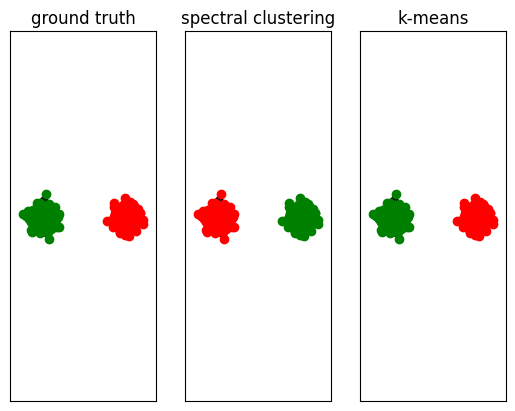

Modularity: 0.4999999613824807


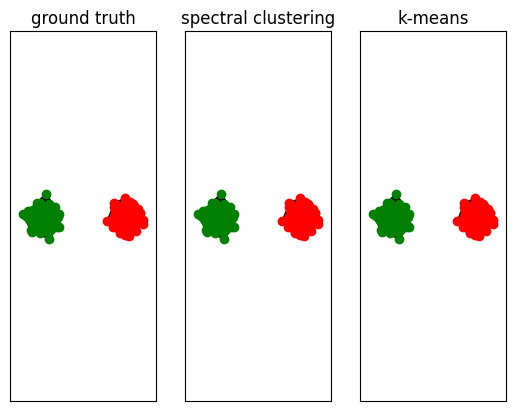

Modularity: 0.49999863700540526


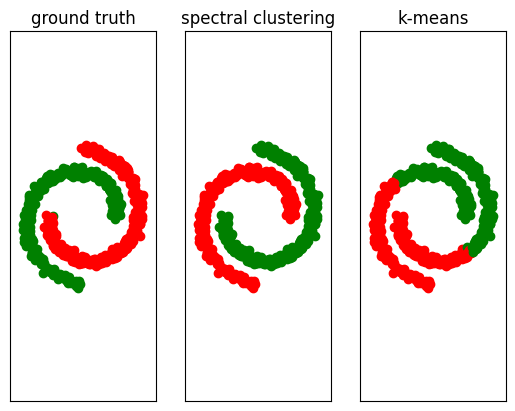

Modularity: 0.49998417866183453


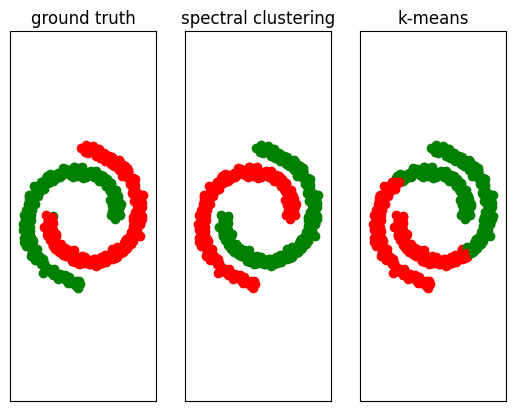

Modularity: 0.49921014149372567


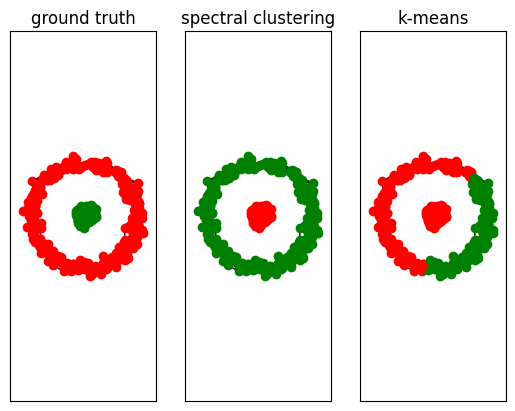

Modularity: 0.16103096136453435


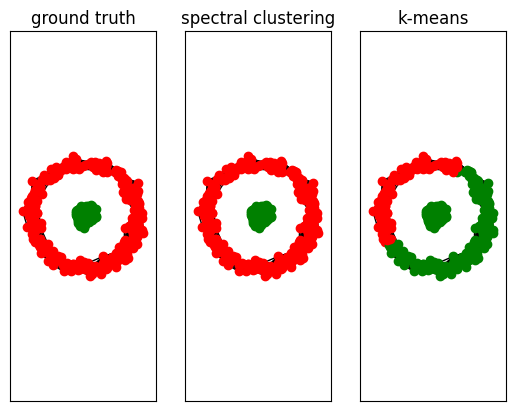

In [11]:
###################################################### Optimal case ########################################################
for func in [blobs, two_moons, point_and_circle]:
    X, Y_true = func(num_samples=600)

####################################### Test for k-NN ########################################################

    # Build a connected graph using k-NN
    k = 12  # empirically chosen
    W = build_similarity_graph(X, k=k)
    G = nx.from_numpy_array(W)

    # Laplacian
    L = build_laplacian(W)
    num_classes = len(np.unique(Y_true))

    # Spectral clustering
    Y_pred = spectral_clustering(L, num_classes=num_classes, threshold=0.2, thresh_method='diff')

    # Partition dictionary to list of sets
    partition = {i: Y_pred[i] for i in range(len(Y_pred))}
    communities = [[] for _ in range(num_classes)]
    for node, community in partition.items():
        communities[community].append(node)
    communities = [set(community) for community in communities]

    modularity_score = nx.algorithms.community.modularity(nx.from_numpy_array(W), communities)

    print(f'Modularity: {modularity_score}')

    # plot clustering results
    plot_clustering_result(X, Y_true, W, Y_pred, KMeans(num_classes).fit_predict(X))

####################################### Test for epsilon ########################################################

    # Build a connected epsilon graph
    eps = 0.8
    W = build_similarity_graph(X, eps=eps)
    G = nx.from_numpy_array(W)

    # Laplacian
    L = build_laplacian(W)
    num_classes = len(np.unique(Y_true))

    # Spectral clustering
    Y_pred = spectral_clustering(L, num_classes=num_classes, threshold=0.2, thresh_method='diff')

    # Partition dictionary to list of sets
    partition = {i: Y_pred[i] for i in range(len(Y_pred))}
    communities = [[] for _ in range(num_classes)]
    for node, community in partition.items():
        communities[community].append(node)
    communities = [set(community) for community in communities]

    modularity_score = nx.algorithms.community.modularity(nx.from_numpy_array(W), communities)

    print(f'Modularity: {modularity_score}')

    # plot clustering results
    plot_clustering_result(X, Y_true, W, Y_pred, KMeans(num_classes).fit_predict(X))

>We observe how relevant modularity is as a measure. It appears here that when the clustering is correct we could expect a value near $0.5$. While the more the clustering is unproper (not wrong but unproper), the lower the score is (lower bounded by $0$).

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

>After some experiments on type parameters, we observe that k-NN graph yield better results than $\epsilon$-graph. A way to see that would be the fact that pixels are compared based on their channel colors which are obviously not smooth. Thus, the distance between two pixels won't give us much information, while the proximity given by the K-NN graph grasp a bit more the clorful pattern.
<br><br>
>Based on the experiments made before on k-NN graph, we can justify that as we are currently facing complex data distribution, we will need optimal parameters computed during Q2.7 : we will use the 'sum' method with a threshold of $0.12$, and use $k=15$.
<br><br>
>We will test the classes parameter to see how many classes are needed :

4 classes--------------------------------------------------


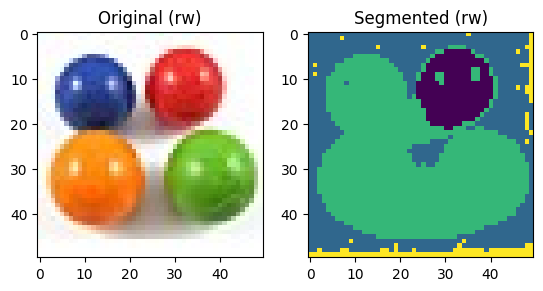

5 classes--------------------------------------------------


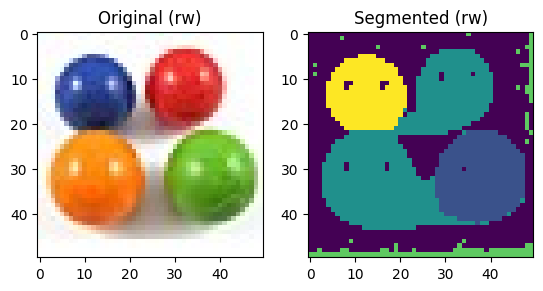

6 classes--------------------------------------------------


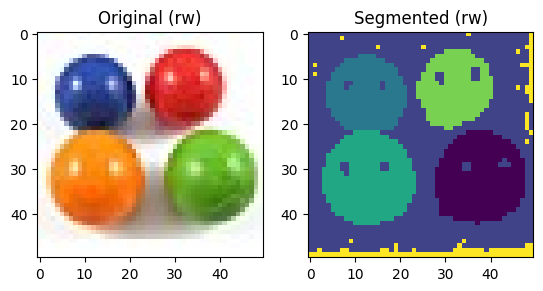

In [52]:
print('4 classes' + '-'*50)
image_segmentation(k=15, laplacian_normalization='rw', num_classes=4, input_img='four_elements.bmp', threshold=0.12, thresh_method='sum')
print('5 classes' + '-'*50)
image_segmentation(k=15, laplacian_normalization='rw', num_classes=5, input_img='four_elements.bmp', threshold=0.12, thresh_method='sum')
print('6 classes' + '-'*50)
image_segmentation(k=15, laplacian_normalization='rw', num_classes=6, input_img='four_elements.bmp', threshold=0.12, thresh_method='sum')

>We decide to chose 2 classes more than the number of classes required (this is because we observe that the spectral clustering tend to give a classes for border pixels). Now, we chose which laplacian method to use :

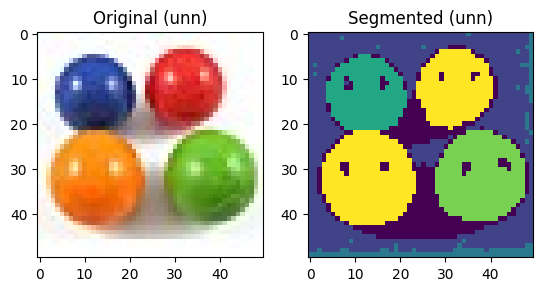

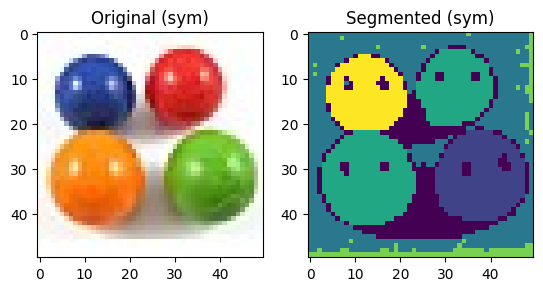

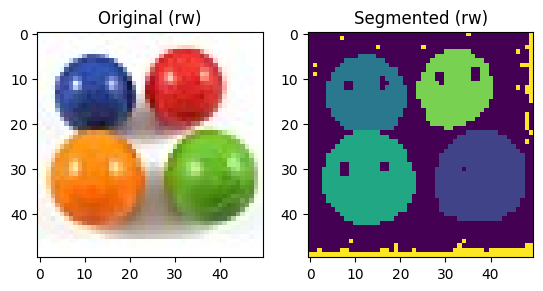

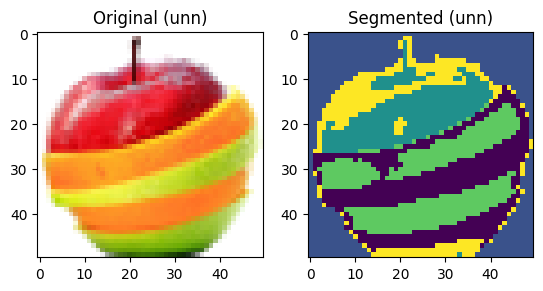

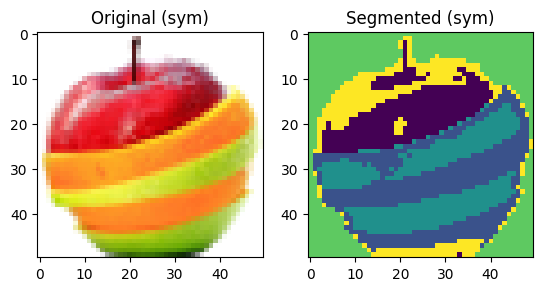

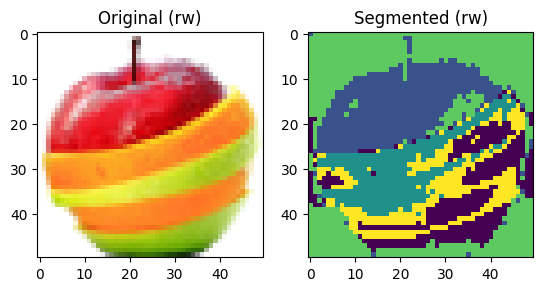

In [53]:
# Segmenting 'four_elements.bmp'
image_segmentation(k=15, laplacian_normalization='unn', num_classes=6, input_img='four_elements.bmp', threshold=0.12, thresh_method='sum')
image_segmentation(k=15, laplacian_normalization='sym', num_classes=6, input_img='four_elements.bmp', threshold=0.12, thresh_method='sum')
image_segmentation(k=15, laplacian_normalization='rw', num_classes=6, input_img='four_elements.bmp', threshold=0.12, thresh_method='sum')


# Segmenting 'fruit_salad.bmp'
image_segmentation(k=15, laplacian_normalization='unn', num_classes=5, input_img='fruit_salad.bmp', threshold=0.12, thresh_method='sum')
image_segmentation(k=15, laplacian_normalization='sym', num_classes=5, input_img='fruit_salad.bmp', threshold=0.12, thresh_method='sum')
image_segmentation(k=15, laplacian_normalization='rw', num_classes=5, input_img='fruit_salad.bmp', threshold=0.12, thresh_method='sum')

>This experiment shows that random walk give us better results. Finally, we plot two good looking segmented images :

Good segmentation : four elements --------------------------------------------------


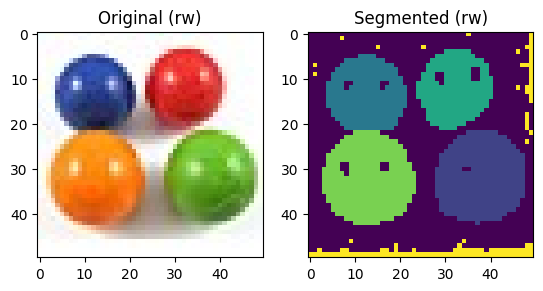

Good segmentation : fruit salad --------------------------------------------------


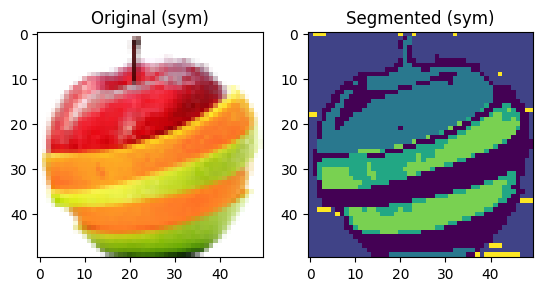

In [57]:
print('Good segmentation : four elements ' + '-'*50)
image_segmentation(k=15, laplacian_normalization='rw', num_classes=6, input_img='four_elements.bmp', threshold=0.12, thresh_method='sum')
print('Good segmentation : fruit salad ' + '-'*50)
image_segmentation(k=15, laplacian_normalization='sym', num_classes=6, input_img='fruit_salad.bmp', threshold=0.12, thresh_method='sum')


### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

>The main goal here is to reduce the scale of our graph. To do so, we could think of graph based method but by doing so we would overlook some fact : The high dimension problem we are facing is due to our images being of high quality. Ultimately, images being of such quality is useless during the segmentation process. Thus, I would suggest to reduce the dimension of our image. In order to reduce dimensionality, we have seen methods like PCA, UMAP, etc. Here, for the specific case of treating high dimensionality images we do not care of those methods with proper defformation for data distribution. We can just reduce the quality using :
<br>
>- Downsampling
<br>
>- Superpixel
<br><br>
Both method are about reducing and averaging pixels into one reduced pixels for each portion of an image. The difference is in how you define those portions. Superpixel is known to keep more efficiently the original image forms/shapes.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

In [36]:
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.color import rgba2rgb

def image_segmentation(input_img='image.bmp', var=1.0, laplacian_normalization='unn', parameter_type='k', k=10, eps=0.8, chosen_eig_indices=None, num_classes=2, threshold=None, thresh_method='sum', method='downsampling', downsample_factor=2, verbose=False):
    """
    Function to perform image segmentation with dimensionality reduction methods.
    
    :param input_img: Name of the image file (e.g., 'image.bmp').
    :param method: Dimensionality reduction method ('downsampling', 'superpixel').
    :param downsample_factor: Factor by which the image is reduced (used for both method).
    :param n_segments: Number of segments for superpixel method.
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X)) 
    n_1 = np.size(X, 0)
    n_2 = np.size(X, 1)
    im_size = n_1 * n_2
    Xr = X.reshape(im_size, 3)  

    # Dimensionality reduction :
    if method == 'downsampling':
        # Downsample the image by averaging in blocks
        X_downsampled = X[::downsample_factor, ::downsample_factor, :]
        # plot the downsampled image
        plt.imshow(X_downsampled)
        plt.show()
        Xr_downsampled = X_downsampled.reshape(-1, 3) 
        Xr_reduced = Xr_downsampled
        print(f"Downsampling: Image size reduced by factor {downsample_factor}")

    elif method == 'superpixel':
        # Downsample the image by averaging in superpixels
        if X.shape[2] == 4:
            X = rgba2rgb(X)
        reduced_size = (n_1 // downsample_factor, n_2 // downsample_factor)
        print(reduced_size)
        num_superpixels = reduced_size[0] * reduced_size[1]
        segments = slic(X, n_segments=num_superpixels, compactness=10, start_label=1)
        reduced_image = label2rgb(segments, X, kind='avg')
        downscaled_image = resize(reduced_image, reduced_size, anti_aliasing=True)
        Xr_reduced = downscaled_image.reshape(-1, 3)
        print(f"Superpixel: Image segmented into {num_superpixels} superpixels")

    else:
        raise ValueError(f"Unknown method '{method}'. Choose from 'downsampling', or 'superpixel'.")

    # Build the similarity graph with reduced data
    # print(Xr_reduced.shape)
    parameter_wrap = {parameter_type: parameter_type, 'eps': eps, 'k': k}
    W = build_similarity_graph(Xr_reduced, var=var, **parameter_wrap)  # Build similarity graph on reduced data
    L = build_laplacian(W, laplacian_normalization)  
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes, threshold=threshold, thresh_method=thresh_method, verbose=verbose)
    if method == 'downsampling':
        Y_rec = Y_rec.reshape(n_1 // downsample_factor + 1, n_2 // downsample_factor + 1)
        # upsample Y_rec to the original size
        Y_rec = np.repeat(np.repeat(Y_rec, downsample_factor, axis=0), downsample_factor, axis=1)
    elif method == 'superpixel':
        Y_rec = Y_rec.reshape(reduced_size[0], reduced_size[1])
        # upsample Y_rec to the original size
        upsampled_image = np.repeat(np.repeat(Y_rec, downsample_factor, axis=0), downsample_factor, axis=1)
        upsampled_image = upsampled_image[:n_1, :n_2]
        # print(upsampled_image.shape)
        Y_rec = upsampled_image

    # Visualize the results
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.title('Original (' + laplacian_normalization + ')')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_rec)
    plt.title('Segmented (' + laplacian_normalization + ')')

    plt.show()




(2831, 1887, 3)


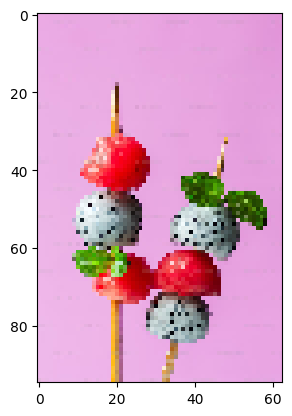

Downsampling: Image size reduced by factor 30
(5985, 3)


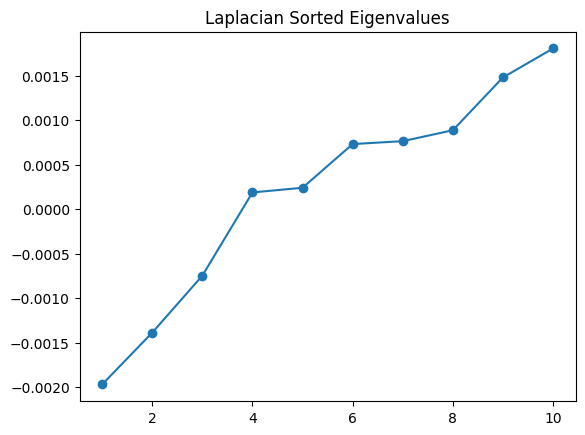

List of eigen values : [0 1 2 3 4 5 6 7 8]
Threshold choice of eigenvectors : 0.005
Adaptative choice of eigenvectors
Number of cluster selected : 8


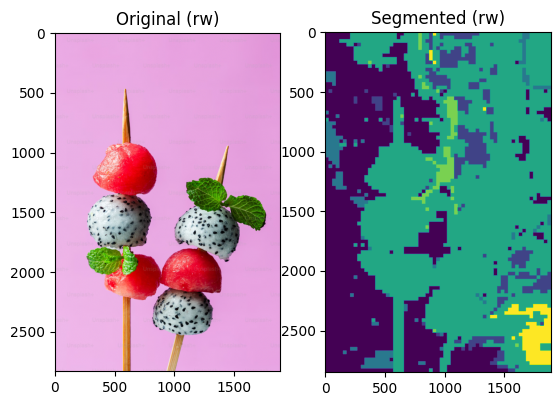

In [10]:
image_segmentation(input_img='image.bmp', var=1.0, laplacian_normalization='rw', 
                   parameter_type='k', k=12, eps=0.8, chosen_eig_indices=None, num_classes=6, 
                   threshold=0.005, thresh_method='sum', method='downsampling', downsample_factor=30, verbose=True)

(94, 62)
Superpixel: Image segmented into 5828 superpixels
(5828, 3)


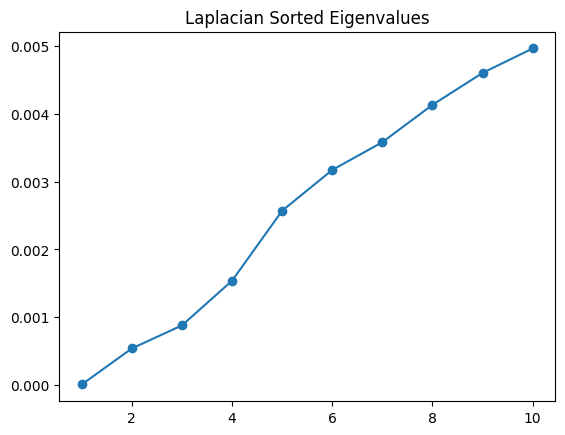

List of eigen values : [0 1]
Threshold choice of eigenvectors : 0.005
Adaptative choice of eigenvectors
Number of cluster selected : 1
(2820, 1860)


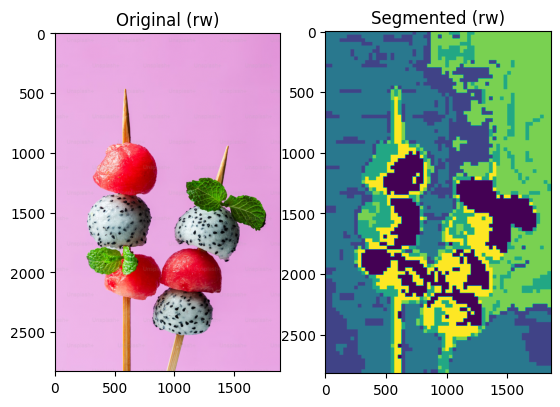

In [37]:
image_segmentation(input_img='image.bmp', var=1.0, laplacian_normalization='rw', 
                   parameter_type='k', k=12, eps=0.8, chosen_eig_indices=None, num_classes=6, 
                   threshold=0.005, thresh_method='sum', method='superpixel', downsample_factor=30, verbose=True)

>Image from Unsplash+ by Patrycja Jadach.

It appears that both methods have a difficulties on correcly keeping the original image clororation and then create some artifacts. The segmentation is unproper but does keeps the form. The main issues comes from the fact that for this image the clustering is difficult because classes are mixed together.